In [1]:
# -------------------------------------------------------------
# This script sets up the Colab environment for interacting with BigQuery and Google Drive.
#
# Purpose:
# - Authenticate the Colab session with Google Cloud services.
# - Initialize the BigQuery client for querying and managing datasets.
# - Mount Google Drive to access project files (e.g., saved CSVs, templates).
# - Load environment variables (such as API keys) securely from a .env file.
#
# Notes:
# - Must run this block at the start of every Colab session.
# - Assumes the .env file is stored at /MyDrive/google/.env.
# - Enables seamless access to BigQuery and external APIs (e.g., Google Places API).
# -------------------------------------------------------------

# %load /content/drive/MyDrive/ColabTemplates/colab_bigquery_startup.txt

# -------------------------------------------------------------
# Authenticate Colab session, initialize BigQuery client, mount Drive.
# -------------------------------------------------------------

!pip install python-dotenv --quiet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Authenticate to Google Cloud
from google.colab import auth
auth.authenticate_user()
print("✅ Colab session authenticated.")

# 2. Initialize BigQuery client
from google.cloud import bigquery
client = bigquery.Client()

# 3. Print authenticated service account
from google.auth import default
creds, _ = default()
try:
    print(f"🔐 Authenticated as: {creds.service_account_email}")
except AttributeError:
    print("🔐 Authenticated, but could not retrieve email.")

# 4. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted.")


✅ Colab session authenticated.
🔐 Authenticated as: default
Mounted at /content/drive
✅ Google Drive mounted.


Then we will process those and make a new table that our models can process, with a name like NextInspections. These will represent the inspections that are coming in the next month or so. ok? Yes or no

In [2]:
# === Create RestaurantProfile_WithFlags Table ===
# This cell creates a new BigQuery table called 'RestaurantProfile_WithFlags'
# by adding binary flag columns (is_cafe, is_bar, is_bakery, etc.)
# based on the 'types' field from the original RestaurantProfile table.
# These flags will later be used as features for machine learning models.


from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL to create a new table with flags
query = """
CREATE OR REPLACE TABLE `hygiene-prediction-434.RestaurantModeling.RestaurantProfile_WithFlags` AS
SELECT
  *,
  CASE WHEN 'cafe' IN UNNEST(types) THEN 1 ELSE 0 END AS is_cafe,
  CASE WHEN 'bar' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bar,
  CASE WHEN 'bakery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bakery,
  CASE WHEN 'meal_takeaway' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_takeaway,
  CASE WHEN 'meal_delivery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_delivery,
  CASE WHEN 'night_club' IN UNNEST(types) THEN 1 ELSE 0 END AS is_night_club
FROM
  `hygiene-prediction-434.RestaurantModeling.RestaurantProfile`
"""

# Run the query
query_job = client.query(query)
query_job.result()

print("✅ RestaurantProfile_WithFlags table created successfully with flags.")


✅ RestaurantProfile_WithFlags table created successfully with flags.


In [3]:
# === Create TrainingData Table by Joining Inspections and Restaurant Profiles ===
# This cell creates a new BigQuery table called 'TrainingData'
# by joining the inspection records (InspectionEvents) with restaurant profiles (RestaurantProfile_WithFlags)
# on the 'place_id' key.
# It **filters out** any inspections where place_id is NULL,
# so only valid, matchable restaurants are included for machine learning model development.

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL query to create the joined TrainingData table
query = """
CREATE OR REPLACE TABLE `hygiene-prediction-434.RestaurantModeling.TrainingData` AS
SELECT
  i.inspection_id,
  i.place_id,
  i.inspection_date,
  i.inspection_type,
  i.result,
  i.violation_codes,
  i.num_violations,
  i.has_critical_violation,
  i.risk,
  r.dba_name,
  r.rating,
  r.price_level,
  r.user_ratings_total,
  r.business_status,
  r.zip,
  r.is_cafe,
  r.is_bar,
  r.is_bakery,
  r.is_meal_takeaway,
  r.is_meal_delivery,
  r.is_night_club
FROM
  `hygiene-prediction-434.RestaurantModeling.InspectionEvents` AS i
LEFT JOIN
  `hygiene-prediction-434.RestaurantModeling.RestaurantProfile_WithFlags` AS r
ON
  i.place_id = r.place_id
WHERE
  i.place_id IS NOT NULL
"""

# Run the query
query_job = client.query(query)
query_job.result()

print("✅ TrainingData table created successfully (place_id NOT NULL).")


✅ TrainingData table created successfully (place_id NOT NULL).


In [4]:

# === Count Rows in TrainingData Table ===
# Quick sanity check to verify the total number of rows after joining inspections and restaurant profiles.

# === Display Schema of TrainingData Table ===
# Prints the column names and types for the TrainingData table to understand available features for modeling.

from google.cloud import bigquery

client = bigquery.Client(project="hygiene-prediction-434")

query = """
SELECT COUNT(*) AS total_rows
FROM `hygiene-prediction-434.RestaurantModeling.TrainingData`
"""

df = client.query(query).to_dataframe()
df

from google.cloud import bigquery

client = bigquery.Client(project="hygiene-prediction-434")

# Fetch schema for the table
table_ref = "hygiene-prediction-434.RestaurantModeling.TrainingData"
table = client.get_table(table_ref)

# Print column names and types
print()
for field in table.schema:
    print(f"{field.name} ({field.field_type})")

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")



,total_rows
0,16169



inspection_id (STRING)
place_id (STRING)
inspection_date (DATE)
inspection_type (STRING)
result (STRING)
violation_codes (STRING)
num_violations (INTEGER)
has_critical_violation (BOOLEAN)
risk (STRING)
dba_name (STRING)
rating (FLOAT)
price_level (INTEGER)
user_ratings_total (INTEGER)
business_status (STRING)
zip (INTEGER)
is_cafe (INTEGER)
is_bar (INTEGER)
is_bakery (INTEGER)
is_meal_takeaway (INTEGER)
is_meal_delivery (INTEGER)
is_night_club (INTEGER)


In [5]:
# ===  Load and Sort Inspections by Place and Date ===
# This cell loads all inspection records from the TrainingData table,
# and sorts them by 'place_id' and 'inspection_date' in ascending order.
# Sorting is necessary to correctly build features based on previous inspections.

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# SQL to fetch and sort inspections
query = """
SELECT
  *
FROM
  `hygiene-prediction-434.RestaurantModeling.TrainingData`
ORDER BY
  place_id,
  inspection_date
"""

# Load into pandas dataframe
df = client.query(query).to_dataframe()

print(f"✅ Loaded {len(df)} inspection records, sorted by place_id and inspection_date.")
df.head()


✅ Loaded 16169 inspection records, sorted by place_id and inspection_date.


,inspection_id,place_id,inspection_date,inspection_type,result,violation_codes,num_violations,has_critical_violation,risk,dba_name,...,price_level,user_ratings_total,business_status,zip,is_cafe,is_bar,is_bakery,is_meal_takeaway,is_meal_delivery,is_night_club
0,2544213,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,canvass,pass,[47],1,True,risk 1 (high),el cangrejo,...,2,1077,OPERATIONAL,60632,0,0,0,0,0,0
1,2586246,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,complaint,pass,"[45, 47, 47, 49, 55, 55, 56, 57]",8,True,risk 2 (medium),whale fish & chicken,...,1,816,OPERATIONAL,60651,0,0,0,0,0,0
2,2603616,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,complaint,pass,"[10, 36, 37, 38, 38, 39, 55]",7,True,risk 2 (medium),whale fish & chicken,...,1,816,OPERATIONAL,60651,0,0,0,0,0,0
3,2591730,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,license,pass,"[47, 49, 55]",3,True,risk 1 (high),obbies pizza,...,2,545,OPERATIONAL,60638,0,0,0,0,1,0
4,2587502,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,license,fail,"[10, 38, 50, 53, 56, 58]",6,True,risk 1 (high),food on the run express,...,<NA>,19,OPERATIONAL,60615,0,0,0,0,0,0


In [6]:
# === Create Fail Flag for Each Inspection ===
# This cell creates a binary 'fail' flag from the 'result' column,
# where 1 = failed inspection, 0 = passed or other outcomes.

df['fail'] = df['result'].apply(lambda x: 1 if x == 'fail' else 0)

print("✅ Created 'fail' flag for each inspection.")
df[['place_id', 'inspection_date', 'result', 'fail']].head(10)


✅ Created 'fail' flag for each inspection.


,place_id,inspection_date,result,fail
0,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,pass,0
1,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,pass,0
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,pass,0
3,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,pass,0
4,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,fail,1
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,pass,0
6,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2022-07-29,pass w conditions,0
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,pass,0
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,fail,1
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,pass,0


In [7]:
# === Assign Sequential Inspection Number per Restaurant ===
# This cell assigns a sequential number ('inspection_number') to each inspection
# within each 'place_id' group, ordered by inspection_date.
# This will allow us to track past inspections for each restaurant.

import pandas as pd

# Assign a sequential inspection number within each restaurant (place_id)
df['inspection_number'] = df.groupby('place_id').cumcount() + 1

print("✅ Assigned sequential inspection numbers.")
df[['place_id', 'inspection_date', 'inspection_number']].head(10)


✅ Assigned sequential inspection numbers.


,place_id,inspection_date,inspection_number
0,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,1
1,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,1
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,2
3,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,1
4,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,1
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,2
6,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2022-07-29,1
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,2
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,3
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,4


In [8]:
# === Create Features Based on Prior Inspections ===
# This cell creates basic historical features for each inspection,
# using information from *previous* inspections (within the same place_id).
# Features include:
# - Total number of prior inspections
# - Total number of prior critical violations
# - Average number of violations per prior inspection
# These features will help predict the outcome of the next inspection.

# Create features:
# Total prior inspections = inspection_number - 1
df['total_prior_inspections'] = df['inspection_number'] - 1

# Total prior critical violations (cumulative sum minus current row)
df['prior_critical_violations'] = (
    df.groupby('place_id')['has_critical_violation']
    .cumsum()
    .shift(1)
    .fillna(0)
)

# Total prior violations (cumulative sum of num_violations minus current row)
df['prior_total_violations'] = (
    df.groupby('place_id')['num_violations']
    .cumsum()
    .shift(1)
    .fillna(0)
)

# Average prior violations per inspection
df['avg_prior_violations_per_inspection'] = (
    df['prior_total_violations'] / df['total_prior_inspections']
)
df['avg_prior_violations_per_inspection'] = df['avg_prior_violations_per_inspection'].fillna(0)

print("✅ Created historical features based on prior inspections.")
df[['place_id', 'inspection_date', 'inspection_number', 'total_prior_inspections', 'prior_critical_violations', 'avg_prior_violations_per_inspection']].head(10)


✅ Created historical features based on prior inspections.


,place_id,inspection_date,inspection_number,total_prior_inspections,prior_critical_violations,avg_prior_violations_per_inspection
0,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,1,0,0,NaN
1,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,1,0,1,inf
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,2,1,1,8.0
3,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,1,0,2,inf
4,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,1,0,1,inf
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,2,1,1,6.0
6,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2022-07-29,1,0,1,inf
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,2,1,1,6.0
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,3,2,2,7.0
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,4,3,3,7.333333


In [9]:
# === Create Fail Rate Feature (Past Failures Normalized by Inspections) ===
# This cell creates a 'fail_rate' feature for each inspection,
# defined as (prior failures) divided by (total prior inspections).

# First, cumulative sum of past failures
df['prior_failures'] = (
    df.groupby('place_id')['fail']
    .cumsum()
    .shift(1)
    .fillna(0)
)

# Now compute fail rate
df['fail_rate'] = df['prior_failures'] / df['total_prior_inspections']

# Fill any NaN resulting from division by 0 with 0 (should only happen for bad data, but safe)
df['fail_rate'] = df['fail_rate'].fillna(0)

print("✅ Created prior_failures and fail_rate features.")
df[['place_id', 'inspection_date', 'inspection_number', 'prior_failures', 'fail_rate']].head(10)


✅ Created prior_failures and fail_rate features.


,place_id,inspection_date,inspection_number,prior_failures,fail_rate
0,ChIJ--FstJkxDogRHJ03M57gUqo,2021-11-15,1,0.0,0.000000
1,ChIJ--SRaLUyDogRrDp1lJG2siE,2023-12-04,1,0.0,0.000000
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,2,0.0,0.000000
3,ChIJ--eTTcQ2DogRo5eiOpT5-po,2024-03-27,1,0.0,0.000000
4,ChIJ-0L3BegvDogRrtvLYG1UV4A,2023-12-28,1,0.0,0.000000
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,2,1.0,1.000000
6,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2022-07-29,1,1.0,inf
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,2,0.0,0.000000
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,3,0.0,0.000000
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,4,1.0,0.333333


In [10]:
# === Drop First Inspections (No Prior History Available) ===
# This cell removes inspections where 'inspection_number' == 1,
# because these inspections have no historical data to use for feature engineering.
# Only inspections with at least one prior inspection will be used for training.

# Keep only inspections where inspection_number > 1
df = df[df['inspection_number'] > 1].copy()

print(f"✅ Remaining {len(df)} inspection records after dropping first inspections (no history).")
df[['place_id', 'inspection_date', 'inspection_number']].head(10)


✅ Remaining 12390 inspection records after dropping first inspections (no history).


,place_id,inspection_date,inspection_number
2,ChIJ--SRaLUyDogRrDp1lJG2siE,2024-09-26,2
5,ChIJ-0L3BegvDogRrtvLYG1UV4A,2024-01-25,2
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,2
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,3
9,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-19,4
11,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2021-11-05,2
12,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2022-10-11,3
13,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2023-04-14,4
14,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2024-07-23,5
15,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2025-03-12,6


In [11]:
# === Define Prediction Targets (Critical Violation and Pass/Fail) ===
# This cell shifts relevant outcome columns upward within each place_id group,
# so that the label (target) for each inspection is the outcome of the *next* inspection.
# Targets:
# - future_has_critical_violation: whether the next inspection had a critical violation
# - future_fail: whether the next inspection resulted in 'fail'

# Shift has_critical_violation to get the next inspection's critical violation result
df['future_has_critical_violation'] = (
    df.groupby('place_id')['has_critical_violation']
    .shift(-1)
)

# Shift 'fail' flag to get the next inspection's failure
df['future_fail'] = (
    df.groupby('place_id')['fail']
    .shift(-1)
)

# Drop rows where future target is missing (i.e., no next inspection exists)
df = df[df['future_has_critical_violation'].notnull()].copy()

print(f"✅ Remaining {len(df)} inspection records with future targets defined (critical violation and fail).")
df[['place_id', 'inspection_date', 'inspection_number', 'has_critical_violation', 'future_has_critical_violation', 'fail', 'future_fail']].head(10)



✅ Remaining 9003 inspection records with future targets defined (critical violation and fail).


,place_id,inspection_date,inspection_number,has_critical_violation,future_has_critical_violation,fail,future_fail
7,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2023-06-07,2,True,True,0,1.0
8,ChIJ-1KJgWrSD4gRlhNCs5-WMz4,2024-08-06,3,True,False,1,0.0
11,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2021-11-05,2,False,True,0,0.0
12,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2022-10-11,3,True,True,0,0.0
13,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2023-04-14,4,True,False,0,0.0
14,ChIJ-1fvBFrMD4gRtz-L-aTBtIU,2024-07-23,5,False,True,0,0.0
17,ChIJ-1sW6nItDogRxDXFMjCqWXI,2023-07-24,2,True,True,1,0.0
18,ChIJ-1sW6nItDogRxDXFMjCqWXI,2023-07-31,3,True,True,0,0.0
21,ChIJ-1yVVAbSD4gRH4SmYFIvs8U,2022-10-05,2,True,True,0,0.0
24,ChIJ-2GXX28pDogR8oof0wT6oOs,2022-05-10,2,True,False,0,0.0


In [32]:
# === Define Target Columns for Different Prediction Tasks ===
# This cell defines separate target columns for different machine learning tasks:
# - target_column_fail: whether the next inspection fails
# - target_column_critical: whether the next inspection has a critical violation
# Target selection will happen dynamically later during model training.

# Define target columns
target_column_fail = 'future_fail'
target_column_critical = 'future_has_critical_violation'

print("✅ Target columns defined:")
print(f"  - Fail Prediction: {target_column_fail}")
print(f"  - Critical Violation Prediction: {target_column_critical}")


✅ Target columns defined:
  - Fail Prediction: future_fail
  - Critical Violation Prediction: future_has_critical_violation


In [33]:
# === Correlation Analysis: Features vs Future Targets ===
# This cell calculates the Pearson correlation between each feature
# and both target labels: future_fail and future_has_critical_violation.

import pandas as pd
import numpy as np

# Calculate correlation

# Define features to check
features_to_check = [
    'total_prior_inspections',
    'prior_critical_violations',
    'prior_total_violations',
    'avg_prior_violations_per_inspection',
    'prior_failures',
    'fail_rate',
    'is_cafe',
    'is_bar',
    'is_bakery',
    'is_meal_takeaway',
    'is_meal_delivery',
    'is_night_club',
    'zip'
]

# Create empty list to collect results
correlation_results = []

# Loop through each feature
for feature in features_to_check:
    corr_fail = np.corrcoef(df[feature], df['future_fail'])[0, 1]
    corr_critical = np.corrcoef(df[feature], df['future_has_critical_violation'])[0, 1]
    correlation_results.append((feature, corr_fail, corr_critical))

# Convert to dataframe
correlation_df = pd.DataFrame(
    correlation_results,
    columns=['feature', 'correlation_with_future_fail', 'correlation_with_future_critical_violation']
)

# Display
print("✅ Feature Correlation with Targets:")
display(correlation_df.sort_values(by='correlation_with_future_fail', ascending=False))



✅ Feature Correlation with Targets:


,feature,correlation_with_future_fail,correlation_with_future_critical_violation
3,avg_prior_violations_per_inspection,0.143254,0.112822
5,fail_rate,0.114998,0.054016
4,prior_failures,0.098419,0.033853
2,prior_total_violations,0.091211,0.060780
1,prior_critical_violations,0.045848,0.037147
0,total_prior_inspections,0.022190,-0.000385
11,is_night_club,0.011975,0.002409
8,is_bakery,0.006805,-0.010125
10,is_meal_delivery,0.003882,0.034120
7,is_bar,-0.006341,-0.020026


In [37]:
# === Define Feature Matrix (X) and Target Vector (y) ===

# Pick the target you want
target_column = target_column_fail
#target_column =target_column_critical

# Feature columns
feature_columns = [
    'total_prior_inspections',
    'prior_critical_violations',
    'prior_total_violations',
    'avg_prior_violations_per_inspection',
    'prior_failures',
    'fail_rate',
    'is_cafe',
    'is_bar',
    'is_bakery',
    'is_meal_takeaway',
    'is_meal_delivery',
    'is_night_club',
    'zip'
]

# Define X and y
X = df[feature_columns]
y = df[target_column]

print(f"✅ Feature matrix X and target vector y defined.")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


✅ Feature matrix X and target vector y defined.
X shape: (9003, 13)
y shape: (9003,)


In [38]:
# === Train/Validation/Test Split ===   BASED ON THE CODE I GAVE YOU, give me a function that generates all the features
# This cell splits the data into:
# - Train set (70%)
# - Validation set (15%)
# - Test set (15%)
# using random shuffling with a fixed random seed for reproducibility.

from sklearn.model_selection import train_test_split

# First split: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: Validation (15%) vs Test (15%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=43, stratify=y_temp
)

print(f"✅ Split complete:")
print(f"  - Training set: {X_train.shape[0]} rows")
print(f"  - Validation set: {X_val.shape[0]} rows")
print(f"  - Test set: {X_test.shape[0]} rows")


✅ Split complete:
  - Training set: 6302 rows
  - Validation set: 1350 rows
  - Test set: 1351 rows


✅ Label counts:
future_fail
0.0    7028
1.0    1975
Name: count, dtype: int64


<Figure size 600x400 with 0 Axes>

<Axes: xlabel='future_fail'>

Text(0.5, 1.0, 'Distribution of Target Labels')

Text(0.5, 0, 'critical violations')

Text(0, 0.5, 'Count')

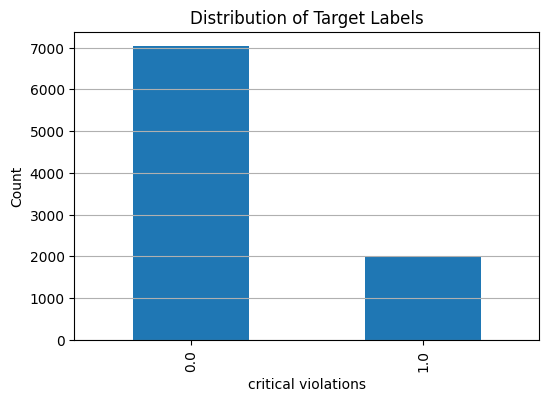

In [39]:
# === Check Class Balance Before Modeling ===
# This cell checks the distribution of the target labels (0 = pass, 1 = fail)
# to understand how imbalanced the data is before training.

import matplotlib.pyplot as plt

# Count labels in y
label_counts = y.value_counts()

print("✅ Label counts:")
print(label_counts)

# Optional: Plot class distribution
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar')
plt.title('Distribution of Target Labels')
plt.xlabel('critical violations')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


In [40]:
# === Train Logistic Regression, Random Forest, XGBoost and Ensemble Their Predictions ===
# This cell trains three different models separately,
# predicts probabilities, averages them, and makes final ensemble predictions.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Initialize all models
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Train models
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# 3. Get predicted probabilities (positive class only) on validation set
logistic_probs = logistic_model.predict_proba(X_val)[:, 1]
rf_probs = rf_model.predict_proba(X_val)[:, 1]
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]

# 4. Average the probabilities
ensemble_probs = (logistic_probs + rf_probs + xgb_probs) / 3

# 5. Choose a threshold (start with 0.5)
threshold = 0.5
ensemble_preds = (ensemble_probs >= threshold).astype(int)

# 6. Evaluate ensemble
print("✅ Ensemble Validation Performance (Threshold = 0.5):")
print(classification_report(y_val, ensemble_preds))

print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, ensemble_preds))


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Ensemble Validation Performance (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80      1054
         1.0       0.28      0.27      0.27       296

    accuracy                           0.69      1350
   macro avg       0.54      0.54      0.54      1350
weighted avg       0.68      0.69      0.68      1350

Validation Confusion Matrix:
[[847 207]
 [216  80]]


<Figure size 800x600 with 0 Axes>

(array([  8.,  11.,  13.,  51.,  51.,  67.,  87.,  90., 100.,  94.,  89.,
         87.,  90.,  63.,  56.,  72.,  60.,  52.,  49.,  40.,  27.,  29.,
         20.,  17.,   7.,   7.,   4.,   5.,   2.,   2.]),
 array([0.12216893, 0.14490337, 0.16763781, 0.19037225, 0.21310669,
        0.23584113, 0.25857558, 0.28131002, 0.30404446, 0.3267789 ,
        0.34951334, 0.37224778, 0.39498223, 0.41771667, 0.44045111,
        0.46318555, 0.48591999, 0.50865443, 0.53138888, 0.55412332,
        0.57685776, 0.5995922 , 0.62232664, 0.64506108, 0.66779553,
        0.69052997, 0.71326441, 0.73599885, 0.75873329, 0.78146773,
        0.80420217]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of Probabilities of Failure')

Text(0.5, 0, 'Predicted Probability of Failure')

Text(0, 0.5, 'Number of Restaurants')

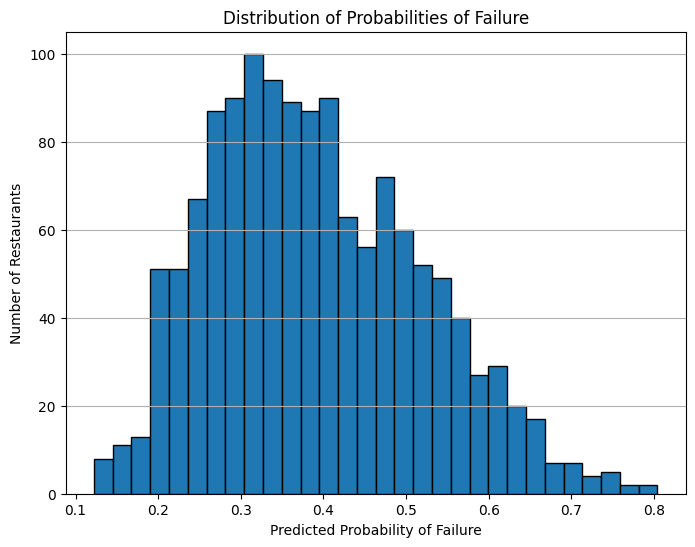

In [51]:
# === Generate and Plot Risk Scores for Critical Events (Ensemble Model) ===
# This cell calculates the probability of critical violation for each place
# and plots a histogram of those probabilities.

import matplotlib.pyplot as plt

# 1. Get ensemble probabilities
# Assuming you've already computed:
# logistic_probs, rf_probs, xgb_probs for validation set

ensemble_probs = (logistic_probs + rf_probs + xgb_probs) / 3

# 2. Plot histogram
plt.figure(figsize=(8,6))
plt.hist(ensemble_probs, bins=30, edgecolor='black')
# plt.title('Distribution of Probabilities of Critical Violations')
# plt.xlabel('Predicted Probability of Critical Violation')
plt.title('Distribution of Probabilities of Failure')
plt.xlabel('Predicted Probability of Failure')
plt.ylabel('Number of Restaurants')
plt.grid(axis='y')
plt.show()


In [52]:
import joblib
import os
import numpy as np  # <-- Make sure numpy is imported

# 1. Set save directory
models_dir = '/content/drive/MyDrive/msds434_project/models/'
os.makedirs(models_dir, exist_ok=True)

# 2. Group three models into one dictionary
ensemble_splitter = {
    "logistic_model": logistic_model,
    "rf_model": rf_model,
    "xgb_model": xgb_model
}

# 3. Compute median threshold from predicted probabilities
# (Make sure y_probs is already computed from your models)
median_threshold = np.median(ensemble_probs)

# 4. Save the ensemble splitter dictionary
joblib.dump(ensemble_splitter, os.path.join(models_dir, 'ensemble_splitter_model.pkl'))

# 5. Save the median threshold
joblib.dump(median_threshold, os.path.join(models_dir, 'ensemble_splitter_median.pkl'))

print("✅ Saved ensemble splitter model dictionary.")
print("✅ Saved ensemble splitter median threshold.")



['/content/drive/MyDrive/msds434_project/models/ensemble_splitter_model.pkl']

['/content/drive/MyDrive/msds434_project/models/ensemble_splitter_median.pkl']

✅ Saved ensemble splitter model dictionary.
✅ Saved ensemble splitter median threshold.


In [53]:
# === Median Split and Prepare Low-Risk and High-Risk Datasets ===

import numpy as np

# 1. Calculate median probability
median_prob = np.median(ensemble_probs)
print(f"✅ Median ensemble probability: {median_prob:.4f}")

# 2. Tag each restaurant as low-risk or high-risk
low_risk_idx = ensemble_probs < median_prob
high_risk_idx = ensemble_probs >= median_prob

# 3. Split feature matrix and target vector
X_low = X_val[low_risk_idx]
y_low = y_val[low_risk_idx]

X_high = X_val[high_risk_idx]
y_high = y_val[high_risk_idx]

print(f"✅ Low-risk group: {X_low.shape[0]} examples")
print(f"✅ High-risk group: {X_high.shape[0]} examples")


✅ Median ensemble probability: 0.3758
✅ Low-risk group: 675 examples
✅ High-risk group: 675 examples


In [54]:
# === Train LowRiskModel and HighRiskModel Separately ===

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Initialize models (you can use same settings for now)
low_risk_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_low[y_low == 0]) / len(y_low[y_low == 1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

high_risk_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_high[y_high == 0]) / len(y_high[y_high == 1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Train the models
low_risk_model.fit(X_low, y_low)
high_risk_model.fit(X_high, y_high)

print("✅ LowRiskModel and HighRiskModel trained successfully.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ LowRiskModel and HighRiskModel trained successfully.


In [55]:
# === Separate Evaluation for LowRiskModel and HighRiskModel ===

from sklearn.metrics import classification_report, confusion_matrix

# 1. Predict for Low Risk Group
low_preds = (low_risk_model.predict_proba(X_low)[:, 1] >= 0.5).astype(int)

print("✅ Low Risk Group Performance:")
print(classification_report(y_low, low_preds))
print("Low Risk Group Confusion Matrix:")
print(confusion_matrix(y_low, low_preds))

# 2. Predict for High Risk Group
high_preds = (high_risk_model.predict_proba(X_high)[:, 1] >= 0.5).astype(int)

print("\n✅ High Risk Group Performance:")
print(classification_report(y_high, high_preds))
print("High Risk Group Confusion Matrix:")
print(confusion_matrix(y_high, high_preds))


✅ Low Risk Group Performance:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       536
         1.0       0.83      0.98      0.90       139

    accuracy                           0.95       675
   macro avg       0.91      0.96      0.93       675
weighted avg       0.96      0.95      0.96       675

Low Risk Group Confusion Matrix:
[[508  28]
 [  3 136]]

✅ High Risk Group Performance:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       518
         1.0       0.76      0.99      0.86       157

    accuracy                           0.92       675
   macro avg       0.88      0.95      0.90       675
weighted avg       0.94      0.92      0.93       675

High Risk Group Confusion Matrix:
[[468  50]
 [  1 156]]


In [56]:
# === Score Validation Set Using the Two Specialized Models ===
# This cell routes examples to the appropriate model based on median split
# and combines predictions into one final output.

# 1. Predict probabilities separately
low_probs = low_risk_model.predict_proba(X_low)[:, 1]
high_probs = high_risk_model.predict_proba(X_high)[:, 1]

# 2. Combine probabilities into one aligned array
# (initialize full-size array)
final_probs = np.zeros_like(ensemble_probs)

# Fill based on the split
final_probs[low_risk_idx] = low_probs
final_probs[high_risk_idx] = high_probs

# 3. Set threshold (you can tune this later — start with 0.5)
threshold = 0.5
final_preds = (final_probs >= threshold).astype(int)

# 4. Evaluate
print("✅ Combined Two-Model Validation Performance (Threshold = 0.5):")
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_val, final_preds))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, final_preds))


✅ Combined Two-Model Validation Performance (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      1054
         1.0       0.79      0.99      0.88       296

    accuracy                           0.94      1350
   macro avg       0.89      0.96      0.92      1350
weighted avg       0.95      0.94      0.94      1350

Validation Confusion Matrix:
[[976  78]
 [  4 292]]


In [57]:
# === Final Test Set Evaluation: Route Test Data and Predict ===

# 1. Get ensemble probabilities for test set
# (You must have trained logistic_model, rf_model, xgb_model already)

logistic_test_probs = logistic_model.predict_proba(X_test)[:, 1]
rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

ensemble_test_probs = (logistic_test_probs + rf_test_probs + xgb_test_probs) / 3

# 2. Median split based on test ensemble probabilities
median_prob_test = np.median(ensemble_test_probs)
print(f"✅ Test set median ensemble probability: {median_prob_test:.4f}")

low_risk_test_idx = ensemble_test_probs < median_prob_test
high_risk_test_idx = ensemble_test_probs >= median_prob_test

X_low_test = X_test[low_risk_test_idx]
y_low_test = y_test[low_risk_test_idx]

X_high_test = X_test[high_risk_test_idx]
y_high_test = y_test[high_risk_test_idx]

# 3. Predict with the correct model
low_test_preds = (low_risk_model.predict_proba(X_low_test)[:, 1] >= 0.5).astype(int)
high_test_preds = (high_risk_model.predict_proba(X_high_test)[:, 1] >= 0.5).astype(int)

# 4. Combine predictions
final_test_preds = np.zeros_like(ensemble_test_probs, dtype=int)
final_test_preds[low_risk_test_idx] = low_test_preds
final_test_preds[high_risk_test_idx] = high_test_preds

# 5. Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("✅ Final Test Set Performance (Two-Model System):")
print(classification_report(y_test, final_test_preds))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, final_test_preds))


✅ Test set median ensemble probability: 0.3753
✅ Final Test Set Performance (Two-Model System):
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      1405
         1.0       0.35      0.36      0.36       395

    accuracy                           0.71      1800
   macro avg       0.58      0.59      0.58      1800
weighted avg       0.72      0.71      0.71      1800

Test Set Confusion Matrix:
[[1134  271]
 [ 251  144]]


In [58]:
# === Full Clean Two-Model System with K-Fold Cross Validation Predicting failure ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')  # Suppress warnings for clean output

# 1. Define features and target
feature_columns = [
    'total_prior_inspections',
    'prior_critical_violations',
    'prior_total_violations',
    'avg_prior_violations_per_inspection',
    'prior_failures',
    'fail_rate',
    'is_cafe',
    'is_bar',
    'is_bakery',
    'is_meal_takeaway',
    'is_meal_delivery',
    'is_night_club',
    'zip'
]

target_column = 'future_fail'

X = df[feature_columns]
y = df[target_column]

# 2. Setup 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
all_reports = []

for train_idx, test_idx in kf.split(X, y):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 3. Train base models
    logistic_model = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
    xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                              scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
                              random_state=42, verbosity=0, eval_metric='logloss')

    logistic_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # 4. Ensemble probabilities
    logistic_test_probs = logistic_model.predict_proba(X_test)[:, 1]
    rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
    xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

    ensemble_test_probs = (logistic_test_probs + rf_test_probs + xgb_test_probs) / 3

    # 5. Median split
    median_prob_test = np.median(ensemble_test_probs)

    low_risk_test_idx = ensemble_test_probs < median_prob_test
    high_risk_test_idx = ensemble_test_probs >= median_prob_test

    X_low = X_test[low_risk_test_idx]
    y_low = y_test[low_risk_test_idx]

    X_high = X_test[high_risk_test_idx]
    y_high = y_test[high_risk_test_idx]

    # 6. Train two specialized models
    low_risk_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                   scale_pos_weight=(len(y_low[y_low == 0]) / len(y_low[y_low == 1])),
                                   random_state=42, verbosity=0, eval_metric='logloss')

    high_risk_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                    scale_pos_weight=(len(y_high[y_high == 0]) / len(y_high[y_high == 1])),
                                    random_state=42, verbosity=0, eval_metric='logloss')

    low_risk_model.fit(X_low, y_low)
    high_risk_model.fit(X_high, y_high)

    # 7. Predict using specialized models
    low_preds = (low_risk_model.predict_proba(X_low)[:, 1] >= 0.5).astype(int)
    high_preds = (high_risk_model.predict_proba(X_high)[:, 1] >= 0.5).astype(int)

    final_test_preds = np.zeros_like(ensemble_test_probs, dtype=int)
    final_test_preds[low_risk_test_idx] = low_preds
    final_test_preds[high_risk_test_idx] = high_preds

    # 8. Evaluate
    report = classification_report(y_test, final_test_preds, output_dict=True)
    confusion = confusion_matrix(y_test, final_test_preds)

    print(f"✅ Fold {fold} Accuracy: {report['accuracy']:.4f}")
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion)

    all_reports.append(report)
    fold += 1

# 9. Average final metrics across folds
avg_accuracy = np.mean([r['accuracy'] for r in all_reports])
avg_recall_fail = np.mean([r['1.0']['recall'] for r in all_reports])
avg_precision_fail = np.mean([r['1.0']['precision'] for r in all_reports])
avg_f1_fail = np.mean([r['1.0']['f1-score'] for r in all_reports])

print("\n=== Final Cross-Validation Results ===")
print(f"✅ Average Accuracy: {avg_accuracy:.4f}")
print(f"✅ Average Precision (Failures): {avg_precision_fail:.4f}")
print(f"✅ Average Recall (Failures): {avg_recall_fail:.4f}")
print(f"✅ Average F1-score (Failures): {avg_f1_fail:.4f}")




=== Fold 1 ===


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Fold 1 Accuracy: 0.9167
Fold 1 Confusion Matrix:
[[1275  131]
 [  19  376]]

=== Fold 2 ===


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Fold 2 Accuracy: 0.9156
Fold 2 Confusion Matrix:
[[1272  134]
 [  18  377]]

=== Fold 3 ===


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Fold 3 Accuracy: 0.9284
Fold 3 Confusion Matrix:
[[1294  112]
 [  17  378]]

=== Fold 4 ===


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Fold 4 Accuracy: 0.9311
Fold 4 Confusion Matrix:
[[1298  107]
 [  17  378]]

=== Fold 5 ===


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

RandomForestClassifier(class_weight='balanced', random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

✅ Fold 5 Accuracy: 0.9139
Fold 5 Confusion Matrix:
[[1263  142]
 [  13  382]]

=== Final Cross-Validation Results ===
✅ Average Accuracy: 0.9211
✅ Average Precision (Failures): 0.7518
✅ Average Recall (Failures): 0.9575
✅ Average F1-score (Failures): 0.8421


In [59]:
# === Full Two-Model System with K-Fold CV for Critical Violations ===

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import warnings
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# warnings.filterwarnings('ignore')

# # 1. Define features and new target (CRITICAL VIOLATION prediction)
# feature_columns = [
#     'total_prior_inspections',
#     'prior_critical_violations',
#     'prior_total_violations',
#     'avg_prior_violations_per_inspection',
#     'prior_failures',
#     'fail_rate',
#     'is_cafe',
#     'is_bar',
#     'is_bakery',
#     'is_meal_takeaway',
#     'is_meal_delivery',
#     'is_night_club',
#     'zip'
# ]

# target_column = 'future_has_critical_violation'

# X = df[feature_columns]
# y = df[target_column]

# # 2. Setup 5-Fold Cross Validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# fold = 1
# all_reports = []
# balanced_accuracies = []

# for train_idx, test_idx in kf.split(X, y):
#     print(f"\n=== Fold {fold} ===")

#     # Split data
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#     # 3. Train base models
#     logistic_model = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
#     rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
#     xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
#                               scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
#                               random_state=42, verbosity=0, eval_metric='logloss')

#     logistic_model.fit(X_train, y_train)
#     rf_model.fit(X_train, y_train)
#     xgb_model.fit(X_train, y_train)

#     # 4. Ensemble probabilities
#     logistic_test_probs = logistic_model.predict_proba(X_test)[:, 1]
#     rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
#     xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

#     ensemble_test_probs = (logistic_test_probs + rf_test_probs + xgb_test_probs) / 3

#     # 5. Median split
#     median_prob_test = np.median(ensemble_test_probs)

#     low_risk_test_idx = ensemble_test_probs < median_prob_test
#     high_risk_test_idx = ensemble_test_probs >= median_prob_test

#     X_low = X_test[low_risk_test_idx]
#     y_low = y_test[low_risk_test_idx]

#     X_high = X_test[high_risk_test_idx]
#     y_high = y_test[high_risk_test_idx]

#     # 6. Train two specialized models
#     low_risk_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
#                                    scale_pos_weight=(len(y_low[y_low == 0]) / len(y_low[y_low == 1])),
#                                    random_state=42, verbosity=0, eval_metric='logloss')

#     high_risk_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
#                                     scale_pos_weight=(len(y_high[y_high == 0]) / len(y_high[y_high == 1])),
#                                     random_state=42, verbosity=0, eval_metric='logloss')

#     low_risk_model.fit(X_low, y_low)
#     high_risk_model.fit(X_high, y_high)

#     # 7. Predict using specialized models
#     low_preds = (low_risk_model.predict_proba(X_low)[:, 1] >= 0.5).astype(int)
#     high_preds = (high_risk_model.predict_proba(X_high)[:, 1] >= 0.5).astype(int)

#     final_test_preds = np.zeros_like(ensemble_test_probs, dtype=int)
#     final_test_preds[low_risk_test_idx] = low_preds
#     final_test_preds[high_risk_test_idx] = high_preds

#     # 8. Evaluate
#     report = classification_report(y_test, final_test_preds, output_dict=True)
#     confusion = confusion_matrix(y_test, final_test_preds)
#     bal_acc = balanced_accuracy_score(y_test, final_test_preds)

#     print(f"✅ Fold {fold} Accuracy: {report['accuracy']:.4f}")
#     print(f"✅ Fold {fold} Balanced Accuracy: {bal_acc:.4f}")
#     print(f"Fold {fold} Confusion Matrix:")
#     print(confusion)

#     all_reports.append(report)
#     balanced_accuracies.append(bal_acc)
#     fold += 1

# # 9. Average final metrics across folds
# avg_accuracy = np.mean([r['accuracy'] for r in all_reports])
# avg_recall_fail = np.mean([r['1.0']['recall'] for r in all_reports])
# avg_precision_fail = np.mean([r['1.0']['precision'] for r in all_reports])
# avg_f1_fail = np.mean([r['1.0']['f1-score'] for r in all_reports])
# avg_bal_acc = np.mean(balanced_accuracies)

# print("\n=== Final Cross-Validation Results ===")
# print(f"✅ Average Accuracy: {avg_accuracy:.4f}")
# print(f"✅ Average Precision (Critical Violation): {avg_precision_fail:.4f}")
# print(f"✅ Average Recall (Critical Violation): {avg_recall_fail:.4f}")
# print(f"✅ Average F1-score (Critical Violation): {avg_f1_fail:.4f}")
# print(f"✅ Average Balanced Accuracy: {avg_bal_acc:.4f}")

# # 10. Plot Balanced Accuracy Across Folds
# plt.figure(figsize=(8,5))
# plt.plot(range(1,6), balanced_accuracies, marker='o')
# plt.title('Balanced Accuracy Across Folds (Predicting Critical Violations)')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Accuracy')
# plt.ylim(0, 1)
# plt.grid()
# plt.show()


In [60]:
# === Mount Google Drive ===
from google.colab import drive
import os
import joblib

# Mount drive
drive.mount('/content/drive')

# 1. Set your save directory
save_dir = '/content/drive/MyDrive/msds434_project/models/'

# 2. Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# 3. Save models
joblib.dump(logistic_model, os.path.join(save_dir, 'logistic_model.pkl'))
joblib.dump(rf_model, os.path.join(save_dir, 'rf_model.pkl'))
joblib.dump(xgb_model, os.path.join(save_dir, 'xgb_model.pkl'))
joblib.dump(low_risk_model, os.path.join(save_dir, 'low_risk_model.pkl'))
joblib.dump(high_risk_model, os.path.join(save_dir, 'high_risk_model.pkl'))

# 4. Save extra important objects (feature list and median threshold)
joblib.dump(feature_columns, os.path.join(save_dir, 'feature_columns.pkl'))
joblib.dump(median_prob_test, os.path.join(save_dir, 'median_threshold.pkl'))

print(f"✅ All models and objects saved to {save_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/msds434_project/models/logistic_model.pkl']

['/content/drive/MyDrive/msds434_project/models/rf_model.pkl']

['/content/drive/MyDrive/msds434_project/models/xgb_model.pkl']

['/content/drive/MyDrive/msds434_project/models/low_risk_model.pkl']

['/content/drive/MyDrive/msds434_project/models/high_risk_model.pkl']

['/content/drive/MyDrive/msds434_project/models/feature_columns.pkl']

['/content/drive/MyDrive/msds434_project/models/median_threshold.pkl']

✅ All models and objects saved to /content/drive/MyDrive/msds434_project/models/


In [70]:
# === Save Models to GCS Bucket (ML-models) ===
from google.cloud import storage
import joblib
import tempfile
import os

# 1. Set up your GCS bucket and client
bucket_name = 'ml-prediction-models'  # <-- Your GCS bucket name
gcs_prefix = 'models/'     # Optional folder inside bucket (keep things organized)

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

# 2. Local temp directory for staging
temp_dir = tempfile.mkdtemp()

# 3. Define your model objects
models_to_save = {
    'logistic_model.pkl': logistic_model,
    'rf_model.pkl': rf_model,
    'xgb_model.pkl': xgb_model,
    'low_risk_model.pkl': low_risk_model,
    'high_risk_model.pkl': high_risk_model,
    'feature_columns.pkl': feature_columns,
    'median_threshold.pkl': median_prob_test
}

# 4. Save locally then upload each to GCS
for filename, model_obj in models_to_save.items():
    local_path = os.path.join(temp_dir, filename)

    # Save to local temp file
    joblib.dump(model_obj, local_path)

    # Upload to GCS
    blob = bucket.blob(f'{gcs_prefix}{filename}')
    blob.upload_from_filename(local_path)
    print(f"✅ Uploaded {filename} to gs://{bucket_name}/{gcs_prefix}{filename}")

print("✅✅ All models and objects successfully saved to GCS bucket!")


['/tmp/tmpmkmfp9d8/logistic_model.pkl']

✅ Uploaded logistic_model.pkl to gs://ml-prediction-models/models/logistic_model.pkl


['/tmp/tmpmkmfp9d8/rf_model.pkl']

✅ Uploaded rf_model.pkl to gs://ml-prediction-models/models/rf_model.pkl


['/tmp/tmpmkmfp9d8/xgb_model.pkl']

✅ Uploaded xgb_model.pkl to gs://ml-prediction-models/models/xgb_model.pkl


['/tmp/tmpmkmfp9d8/low_risk_model.pkl']

✅ Uploaded low_risk_model.pkl to gs://ml-prediction-models/models/low_risk_model.pkl


['/tmp/tmpmkmfp9d8/high_risk_model.pkl']

✅ Uploaded high_risk_model.pkl to gs://ml-prediction-models/models/high_risk_model.pkl


['/tmp/tmpmkmfp9d8/feature_columns.pkl']

✅ Uploaded feature_columns.pkl to gs://ml-prediction-models/models/feature_columns.pkl


['/tmp/tmpmkmfp9d8/median_threshold.pkl']

✅ Uploaded median_threshold.pkl to gs://ml-prediction-models/models/median_threshold.pkl
✅✅ All models and objects successfully saved to GCS bucket!


# Full Automated Risk Generator Function

# Run Report Pipeline
- Open save ML models
- Select new restaurants to predict pass/fail next inspection
- Build engineered features - prepare_features
- Apply ML models and compute prob failure
- Score high / medium/ low risk or Not Enough History
- Run report generation, save to csv and to BigQuery table



# === Full Risk Scoring System Overview ===

1. pull_random_place_ids(n)
    - Pulls N random restaurant place_ids from RestaurantProfile
    - (Optional) random seed control in Python

2. run_full_risk_scoring_pipeline(inspector_id, month_year_tag, place_ids)
    - Creates NextRestaurants table in BigQuery
    - Creates NextInspectionEvents table in BigQuery
    - Loads inspection events
    - Engineers historical features:
        - total_prior_inspections
        - prior_critical_violations
        - prior_total_violations
        - avg_prior_violations_per_inspection
        - prior_failures
        - fail_rate
    - Joins inspections with restaurant profiles
    - Drops first inspections (inspection_number == 1)
    - Calls generate_and_save_risk_report()

3. generate_and_save_risk_report()
    - Loads trained Logistic, RF, and XGB models
    - Scores restaurants using ensemble average
    - Routes to low-risk or high-risk models based on median threshold
    - Assigns risk_zone: 'high', 'medium', 'low'
    - Selects highest risk inspection per restaurant
    - Calls augment_risk_report_with_unscored()
    - Adds restaurants with no scorable history ("Not enough history")
    - Sorts:
        - Scored restaurants by predicted_failure_probability descending
        - Unscored restaurants listed after scored
    - Saves final report to:
        - Local CSV
        - BigQuery RiskReport table
    - Displays final report

# === Output Tables (BigQuery):
- {inspector_id}_ScoringRun_{month_year_tag}_Restaurants
- {inspector_id}_ScoringRun_{month_year_tag}_InspectionEvents
- {inspector_id}_ScoringRun_{month_year_tag}_ModelInput
- {inspector_id}_ScoringRun_{month_year_tag}_RiskReport




example run
# Pull 30 random restaurants and run scoring for Inspector I4, April 2025
pull_and_score_random(inspector_id='I8', month_year_tag='0425', n=60, top_n=50)


In [77]:
# === Final Full Risk Report Generator with Proper Sorting ===
    # """
    # Full End-to-End Risk Scoring Pipeline for Restaurant Inspections.

    # This function performs the complete risk scoring process:
    # - Accepts a list of place_ids to be scored (either manually selected or pulled randomly)
    # - Pulls restaurant profiles for these place_ids from BigQuery
    # - Pulls all past inspection events for these restaurants from BigQuery
    # - Engineers historical inspection features (fail rate, prior violations, etc.)
    # - Merges inspection features with restaurant profile metadata
    # - Drops first inspections (since no prior history exists)
    # - Scores restaurants using pre-trained ensemble models (Logistic, RF, XGB)
    # - Routes inspections based on ensemble probability threshold into low/high risk models
    # - Generates a risk prioritization report
    # - Augments the report to include all submitted restaurants, even if not scorable
    # - Saves:
    #     - Full feature dataset to BigQuery (ModelInput table)
    #     - Final risk report to BigQuery (RiskReport table)
    # - Displays the final sorted risk report

    # Output tables and files are named dynamically:
    # - Format: {inspector_id}_ScoringRun_{month_year_tag}_Restaurants
    # - Example: I1_ScoringRun_0425_ModelInput, I1_ScoringRun_0425_RiskReport

    # Parameters:
    #     inspector_id (str): Inspector ID (e.g., 'I1', 'I2', etc.)
    #     month_year_tag (str): Month and Year tag for the run (e.g., '0425' for April 2025)
    #     place_ids (list): List of place_ids (str) representing restaurants to score
    #     models_dir (str): Directory path where trained ML models are saved
    #     output_dataset (str): BigQuery dataset where outputs will be saved

    # Returns:
    #     None
    # """

import os
import pandas as pd
import numpy as np
from datetime import datetime
import joblib
from google.cloud import bigquery
from google.cloud import storage
import io
import random

# === Full Final Risk Scoring Pipeline with Augmentation ===

def run_full_risk_scoring_pipeline(inspector_id, month_year_tag, top_n, place_ids, models_dir='/content/drive/MyDrive/msds434_project/models/', output_dataset='hygiene-prediction-434.RestaurantModeling'):
    """
    Full end-to-end risk scoring pipeline:
    - Pull restaurants by given place_ids
    - Pull inspection events
    - Engineer historical features
    - Merge with restaurant profiles
    - Score failure risk using ensemble and specialized models
    - Save model input (full_data) to BigQuery
    - Save risk report to BigQuery

    Parameters:
        inspector_id (str): Inspector ID (e.g., 'I1')
        month_year_tag (str): MonthYear tag (e.g., '0425')
        place_ids (list): List of place_id strings to score
        models_dir (str): Path to saved models
        output_dataset (str): BigQuery dataset

    Returns:
        None
    """


    # Create base run name
    base_name = f"{inspector_id}_ScoringRun_{month_year_tag}"

    client = bigquery.Client(project='hygiene-prediction-434')

    # === Step 1: Create Restaurants Table ===
    query_create_restaurants = f"""
    CREATE OR REPLACE TABLE `{output_dataset}.{base_name}_Restaurants` AS
    SELECT
      place_id,
      dba_name,
      address,
      zip,
      rating,
      price_level,
      user_ratings_total,
      business_status,
      types,
      CASE WHEN 'cafe' IN UNNEST(types) THEN 1 ELSE 0 END AS is_cafe,
      CASE WHEN 'bar' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bar,
      CASE WHEN 'bakery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_bakery,
      CASE WHEN 'meal_takeaway' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_takeaway,
      CASE WHEN 'meal_delivery' IN UNNEST(types) THEN 1 ELSE 0 END AS is_meal_delivery,
      CASE WHEN 'night_club' IN UNNEST(types) THEN 1 ELSE 0 END AS is_night_club
    FROM
      `hygiene-prediction-434.RestaurantModeling.RestaurantProfile`
    WHERE
      place_id IN UNNEST(@place_ids)
    """

    job_config_restaurants = bigquery.QueryJobConfig(
        query_parameters=[bigquery.ArrayQueryParameter("place_ids", "STRING", place_ids)]
    )

    client.query(query_create_restaurants, job_config=job_config_restaurants).result()
    print(f"✅ Created {base_name}_Restaurants table with {len(place_ids)} restaurants.")

    # === Step 2: Create InspectionEvents Table ===
    query_create_inspections = f"""
    CREATE OR REPLACE TABLE `{output_dataset}.{base_name}_InspectionEvents` AS
    SELECT
      i.inspection_id,
      i.place_id,
      i.inspection_date,
      i.inspection_type,
      i.result,
      i.violation_codes,
      i.num_violations,
      i.has_critical_violation,
      i.risk
    FROM
      `hygiene-prediction-434.RestaurantModeling.InspectionEvents` AS i
    INNER JOIN
      `{output_dataset}.{base_name}_Restaurants` AS r
    ON
      i.place_id = r.place_id
    """
    client.query(query_create_inspections).result()
    print(f"✅ Created {base_name}_InspectionEvents table.")

    # === Step 3: Load and Engineer Features ===
    query_load_inspections = f"""
    SELECT
      inspection_id,
      place_id,
      inspection_date,
      inspection_type,
      result,
      violation_codes,
      num_violations,
      has_critical_violation,
      risk
    FROM
      `{output_dataset}.{base_name}_InspectionEvents`
    ORDER BY
      place_id,
      inspection_date
    """
    df_next_inspections = client.query(query_load_inspections).to_dataframe()
    print(f"✅ Loaded {len(df_next_inspections)} rows from {base_name}_InspectionEvents.")

    # Feature Engineering
    df_next_inspections['inspection_date'] = pd.to_datetime(df_next_inspections['inspection_date'])
    df_next_inspections['fail'] = df_next_inspections['result'].apply(lambda x: 1 if x == 'fail' else 0)
    df_next_inspections['inspection_number'] = df_next_inspections.groupby('place_id').cumcount() + 1
    df_next_inspections['total_prior_inspections'] = df_next_inspections['inspection_number'] - 1
    df_next_inspections['prior_critical_violations'] = df_next_inspections.groupby('place_id')['has_critical_violation'].cumsum().shift(1).fillna(0)
    df_next_inspections['prior_total_violations'] = df_next_inspections.groupby('place_id')['num_violations'].cumsum().shift(1).fillna(0)
    df_next_inspections['avg_prior_violations_per_inspection'] = (df_next_inspections['prior_total_violations'] / df_next_inspections['total_prior_inspections']).replace([np.inf, -np.inf], 0).fillna(0)
    df_next_inspections['prior_failures'] = df_next_inspections.groupby('place_id')['fail'].cumsum().shift(1).fillna(0)
    df_next_inspections['fail_rate'] = (df_next_inspections['prior_failures'] / df_next_inspections['total_prior_inspections']).replace([np.inf, -np.inf], 0).fillna(0)
    print(f"✅ Engineered features successfully.")

    # === Step 4: Load Restaurants Metadata ===
    query_load_restaurants = f"""
    SELECT
      place_id,
      dba_name,
      address,
      zip,
      rating,
      price_level,
      user_ratings_total,
      business_status,
      is_cafe,
      is_bar,
      is_bakery,
      is_meal_takeaway,
      is_meal_delivery,
      is_night_club
    FROM
      `{output_dataset}.{base_name}_Restaurants`
    """
    df_restaurants = client.query(query_load_restaurants).to_dataframe()
    print(f"✅ Loaded {len(df_restaurants)} rows from {base_name}_Restaurants.")

    # Merge
    full_data = df_next_inspections.merge(df_restaurants, how='left', on='place_id')
    print(f"✅ Joined inspections with restaurant profiles. Final dataset has {full_data.shape[0]} rows.")

    # Drop first inspections
    full_data = full_data[full_data['total_prior_inspections'] > 0].copy()
    print(f"✅ Dropped first inspections. Remaining {full_data.shape[0]} rows.")

    # === Step 5: Score and Generate Risk Report ===
    top_risk_report = generate_and_save_risk_report(
      full_data,
      models_dir=models_dir,
      original_place_ids=place_ids,
      df_restaurants_metadata=df_restaurants,
      inspector_id=inspector_id,
      month_year_tag=month_year_tag,
      top_n=top_n
    )


    # === Step 6: Save full_data and risk_report to BigQuery ===
    full_data_table = f"{output_dataset}.{base_name}_ModelInput"
    client.load_table_from_dataframe(full_data, full_data_table).result()
    print(f"✅ Saved full_data to BigQuery table: {full_data_table}")

    top_risk_report_table = f"{output_dataset}.{base_name}_RiskReport"
    client.load_table_from_dataframe(top_risk_report, top_risk_report_table).result()
    print(f"✅ Saved risk report to BigQuery table: {top_risk_report_table}")

    # === Step 7: Display Risk Report ===
    display(top_risk_report)

    print("✅ Full risk scoring pipeline completed successfully.")



#def generate_and_save_risk_report(new_data, models_dir, original_place_ids, df_restaurants_metadata, top_n=50, output_dir='/content/drive/MyDrive/msds434_project/outputs/'):
def generate_and_save_risk_report(new_data, models_dir, original_place_ids, df_restaurants_metadata, inspector_id, month_year_tag, top_n=50, output_dir='/content/drive/MyDrive/msds434_project/outputs/'):

    """
    Full scoring pipeline:
    - Loads models and objects
    - Scores new restaurants
    - Ensures one row per restaurant (highest risk)
    - Adds missing restaurants with 'Not enough history'
    - Sorts scored first, unscored second
    - Saves final risk report to Google Drive

    Parameters:
        new_data (DataFrame): New restaurant data with features matching 'feature_columns'
        models_dir (str): Directory where models and objects are saved
        original_place_ids (list): All place_ids that were supposed to be scored
        df_restaurants_metadata (DataFrame): Basic metadata (dba_name, address, zip, place_id)
        top_n (int): Number of top risky restaurants to keep
        output_dir (str): Where to save the risk report CSV

    Returns:
        DataFrame: Final augmented risk report
    """

    # 1. Load models and objects

    def load_joblib_from_gcs(bucket_name, blob_name):
        """Load a joblib object directly from a GCS bucket."""
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        bytes_data = blob.download_as_bytes()
        joblib_obj = joblib.load(io.BytesIO(bytes_data))

        return joblib_obj


    bucket_name = 'ml-prediction-models'

    logistic_model = load_joblib_from_gcs(bucket_name, 'models/logistic_model.pkl')
    rf_model = load_joblib_from_gcs(bucket_name, 'models/rf_model.pkl')
    xgb_model = load_joblib_from_gcs(bucket_name, 'models/xgb_model.pkl')
    low_risk_model = load_joblib_from_gcs(bucket_name, 'models/low_risk_model.pkl')
    high_risk_model = load_joblib_from_gcs(bucket_name, 'models/high_risk_model.pkl')
    feature_columns = load_joblib_from_gcs(bucket_name, 'models/feature_columns.pkl')
    median_threshold = load_joblib_from_gcs(bucket_name, 'models/median_threshold.pkl')


    # logistic_model = joblib.load(os.path.join(models_dir, 'logistic_model.pkl'))
    # rf_model = joblib.load(os.path.join(models_dir, 'rf_model.pkl'))
    # xgb_model = joblib.load(os.path.join(models_dir, 'xgb_model.pkl'))
    # low_risk_model = joblib.load(os.path.join(models_dir, 'low_risk_model.pkl'))
    # high_risk_model = joblib.load(os.path.join(models_dir, 'high_risk_model.pkl'))
    # feature_columns = joblib.load(os.path.join(models_dir, 'feature_columns.pkl'))
    # median_threshold = joblib.load(os.path.join(models_dir, 'median_threshold.pkl'))

    # 2. Prepare input
    X_new = new_data[feature_columns].copy()
    X_new = np.nan_to_num(X_new, nan=0.0, posinf=0.0, neginf=0.0)

    # 3. Score with ensemble
    logistic_probs = logistic_model.predict_proba(X_new)[:, 1]
    rf_probs = rf_model.predict_proba(X_new)[:, 1]
    xgb_probs = xgb_model.predict_proba(X_new)[:, 1]
    ensemble_probs = (logistic_probs + rf_probs + xgb_probs) / 3

    # 4. Routing based on median
    low_risk_idx = ensemble_probs < median_threshold
    high_risk_idx = ensemble_probs >= median_threshold

    # 5. Specialized model predictions
    low_probs = np.zeros_like(ensemble_probs)
    high_probs = np.zeros_like(ensemble_probs)

    if np.sum(low_risk_idx) > 0:
        low_probs[low_risk_idx] = low_risk_model.predict_proba(X_new[low_risk_idx])[:, 1]
    if np.sum(high_risk_idx) > 0:
        high_probs[high_risk_idx] = high_risk_model.predict_proba(X_new[high_risk_idx])[:, 1]

    # 6. Final risk probabilities
    final_probs = np.zeros_like(ensemble_probs)
    final_probs[low_risk_idx] = low_probs[low_risk_idx]
    final_probs[high_risk_idx] = high_probs[high_risk_idx]

    # 7. Assign risk zones
    def assign_risk_zone(prob):
        if prob >= 0.75:
            return 'high'
        elif prob >= 0.5:
            return 'medium'
        else:
            return 'low'

    risk_zones = [assign_risk_zone(prob) for prob in final_probs]

    # 8. Build output DataFrame
    output_scores = pd.DataFrame({
        'predicted_failure_probability': final_probs,
        'risk_zone': risk_zones
    }).reset_index(drop=True)

    # 9. Add metadata if available
    if 'dba_name' in new_data.columns or 'zip' in new_data.columns or 'address' in new_data.columns:
        metadata_cols = [col for col in ['dba_name', 'address', 'zip', 'place_id'] if col in new_data.columns]
        output_scores = new_data[metadata_cols].reset_index(drop=True).join(output_scores)

    # 10. Scoring status
    output_scores['scoring_status'] = output_scores['predicted_failure_probability'].apply(
        lambda x: 'Scored' if pd.notnull(x) else 'Not enough history'
    )

    # 11. Highest risk per restaurant
    output_scores = output_scores.sort_values(by='predicted_failure_probability', ascending=False)
    output_scores = output_scores.drop_duplicates(subset=['place_id'])

    # 12. Augment with missing restaurants
    output_scores = augment_risk_report_with_unscored(output_scores, original_place_ids, df_restaurants_metadata)

    # === FINAL SORT ===
    # 13. Separate scored and unscored
    scored_df = output_scores[output_scores['scoring_status'] == 'Scored'].copy()
    unscored_df = output_scores[output_scores['scoring_status'] == 'Not enough history'].copy()

    # 14. Sort scored restaurants by predicted_failure_probability descending
    scored_df = scored_df.sort_values(by='predicted_failure_probability', ascending=False)

    # 15. Concatenate
    final_risk_report = pd.concat([scored_df, unscored_df], ignore_index=True).head(top_n)

    # 16. Save to CSV
    def upload_df_to_gcs(df, bucket_name, destination_blob_name):
        """Uploads a pandas DataFrame as CSV to a GCS bucket."""
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        csv_data = df.to_csv(index=False)
        blob.upload_from_string(csv_data, content_type='text/csv')
        print(f"✅ Uploaded risk report to: gs://{bucket_name}/{destination_blob_name}")

    # Inside your main function (generate_and_save_risk_report)

    gcs_filename = f"{inspector_id}_{month_year_tag}_risk_report.csv"


    # Upload the final risk report DataFrame
    upload_df_to_gcs(
        final_risk_report,
        bucket_name='restaurant-risk-reports',
        destination_blob_name=gcs_filename
    )

    return final_risk_report



# === Augment Risk Report to Include Unscored Restaurants ===

def augment_risk_report_with_unscored(top_risk_report, original_place_ids, df_restaurants_metadata):
    """
    Ensure every submitted restaurant appears in the final risk report,
    even if no inspection history allowed scoring.

    Parameters:
        top_risk_report (DataFrame): Scored restaurants (subset)
        original_place_ids (list): All place_ids submitted
        df_restaurants_metadata (DataFrame): Metadata table (must have place_id, dba_name, address, zip)

    Returns:
        DataFrame: Final augmented risk report with all restaurants
    """

    # 1. Find missing place_ids
    scored_place_ids = top_risk_report['place_id'].unique()
    missing_place_ids = [pid for pid in original_place_ids if pid not in scored_place_ids]

    print(f"✅ Found {len(missing_place_ids)} restaurants with no scorable inspections.")

    # 2. Build DataFrame for missing restaurants
    missing_df = df_restaurants_metadata[df_restaurants_metadata['place_id'].isin(missing_place_ids)].copy()

    missing_df['predicted_failure_probability'] = float('nan')
    missing_df['risk_zone'] = 'Not Enough History to Score'
    missing_df['scoring_status'] = 'Not enough history'

    # 3. Select columns in right order
    columns = ['dba_name', 'address', 'zip', 'place_id',
               'predicted_failure_probability', 'risk_zone', 'scoring_status']

    missing_df = missing_df[columns]

    # 4. Align top_risk_report to same column order
    top_risk_report = top_risk_report[columns]

    # 5. Combine
    final_risk_report = pd.concat([top_risk_report, missing_df], ignore_index=True)

    # 6. Sort
    final_risk_report = final_risk_report.sort_values(
        by=['risk_zone', 'predicted_failure_probability'],
        ascending=[True, False]
    ).reset_index(drop=True)

    print(f"✅ Final risk report completed: {final_risk_report.shape[0]} restaurants.")

    return final_risk_report


# === Master Function to Pull Random Restaurants and Run Full Scoring ===

def pull_and_score_random(inspector_id, month_year_tag, n=30, top_n=50, seed=42, models_dir='/content/drive/MyDrive/msds434_project/models/', output_dataset='hygiene-prediction-434.RestaurantModeling'):
    """
    Pulls random place_ids and runs the full risk scoring pipeline in one call.

    Parameters:
        inspector_id (str): Inspector ID (e.g., 'I1')
        month_year_tag (str): Month and year tag (e.g., '0425')
        n (int): Number of random restaurants to pull
        seed (int): Optional random seed for reproducibility
        models_dir (str): Path to saved models
        output_dataset (str): BigQuery dataset where results are saved

    Returns:
        None
    """

    # Pull random place_ids
    place_ids = pull_random_place_ids(n=n)

    # Run full pipeline
    run_full_risk_scoring_pipeline(
        inspector_id=inspector_id,
        month_year_tag=month_year_tag,
        top_n=top_n,
        place_ids=place_ids,
        models_dir=models_dir,
        output_dataset=output_dataset
    )


def pull_random_place_ids(n=30, seed=42):
    """
    Pulls n random place_ids from the RestaurantProfile table.

    Parameters:
        n (int): Number of place_ids to pull
        seed (int): Random seed for reproducibility (optional)

    Returns:
        list: List of random place_ids
    """
    client = bigquery.Client(project='hygiene-prediction-434')

    query = """
    SELECT place_id
    FROM `hygiene-prediction-434.RestaurantModeling.RestaurantProfile`
    WHERE business_status = 'OPERATIONAL'
    """

    df = client.query(query).to_dataframe()

    if seed is not None:
        random.seed(seed)

    place_ids = random.sample(df['place_id'].tolist(), n)

    print(f"✅ Pulled {n} random place_ids.")

    return place_ids



In [78]:
# Pull 30 random restaurants and run scoring for Inspector I4, April 2025
pull_and_score_random(inspector_id='I6', month_year_tag='04-28-2025', n=60, top_n=50,seed=43)


✅ Pulled 60 random place_ids.
✅ Created I6_ScoringRun_04-28-2025_Restaurants table with 60 restaurants.
✅ Created I6_ScoringRun_04-28-2025_InspectionEvents table.
✅ Loaded 208 rows from I6_ScoringRun_04-28-2025_InspectionEvents.
✅ Engineered features successfully.
✅ Loaded 60 rows from I6_ScoringRun_04-28-2025_Restaurants.
✅ Joined inspections with restaurant profiles. Final dataset has 208 rows.
✅ Dropped first inspections. Remaining 169 rows.
✅ Found 22 restaurants with no scorable inspections.
✅ Final risk report completed: 60 restaurants.
✅ Uploaded risk report to: gs://restaurant-risk-reports/I6_04-28-2025_risk_report.csv
✅ Saved full_data to BigQuery table: hygiene-prediction-434.RestaurantModeling.I6_ScoringRun_04-28-2025_ModelInput
✅ Saved risk report to BigQuery table: hygiene-prediction-434.RestaurantModeling.I6_ScoringRun_04-28-2025_RiskReport


,dba_name,address,zip,place_id,predicted_failure_probability,risk_zone,scoring_status
0,three happiness restaurant,209 W Cermak Rd,60616,ChIJUyvwyGMsDogRNY75VYWxRPw,0.949753,high,Scored
1,taco sur birreria,3059 S Pulaski Rd,60623,ChIJG8AA8_IzDogR3Xk0Vb5iHYE,0.883187,high,Scored
2,"chan's king wok, inc.",2323 W Madison St,60612,ChIJnZAXnUMtDogRA5MzcijWw2A,0.876903,high,Scored
3,deep purpl,1137 W Sheridan Rd,60660,ChIJs6ZP2-vRD4gRKCLi-TlxIak,0.874772,high,Scored
4,central gyros corp,3127 N Central Ave,60634,ChIJ1eUUAojMD4gRtxwibG4nUSg,0.870514,high,Scored
5,viet nam restaurant,1032 W Argyle St,60640,ChIJid4OENXTD4gRhqgIpnSGnY4,0.868299,high,Scored
6,baba's famous steaks & lemondade,7500 S Cottage Grove Ave,60619,ChIJxUlCYlIpDogR_kD2Y5lzX5E,0.855623,high,Scored
7,wendys old fashioned hamburgers,758 W 117th St,60628,ChIJ5bN5y0YkDogRsLOqK27ffME,0.853832,high,Scored
8,han 202,605 W 31st St,60616,ChIJEeM05EAsDogRNfAVOvYxQz0,0.841328,high,Scored
9,bacino's of lincoln park ltd,2204 N Lincoln Ave,60614,ChIJm93Wl23TD4gRrSWlWSTrwNw,0.819611,high,Scored


✅ Full risk scoring pipeline completed successfully.


# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


# Below Be Dragons

In [79]:
from google.cloud import storage
import os
import glob

# 1. Mount Drive (if not already)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. Set up
local_folder = '/content/drive/MyDrive/msds434_project/'
pattern = 'places_batch_checkpoint_start_offset_*.csv'
gcs_bucket_name = 'restaurant-enrichment-data'

# 3. Initialize GCS client
storage_client = storage.Client()
bucket = storage_client.bucket(gcs_bucket_name)

# 4. Find all matching files
csv_files = glob.glob(os.path.join(local_folder, pattern))
print(f"✅ Found {len(csv_files)} files to upload.")

# 5. Upload all files
for local_file in csv_files:
    # Get only the filename
    filename = os.path.basename(local_file)
    # Define where it will go in GCS (you can add a subfolder if you want)
    blob = bucket.blob(filename)

    # Upload
    blob.upload_from_filename(local_file)
    print(f"✅ Uploaded {filename} to gs://{gcs_bucket_name}/{filename}")


Mounted at /content/drive
✅ Found 10 files to upload.
✅ Uploaded places_batch_checkpoint_start_offset_0.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_0.csv
✅ Uploaded places_batch_checkpoint_start_offset_1000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_1000.csv
✅ Uploaded places_batch_checkpoint_start_offset_2000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_2000.csv
✅ Uploaded places_batch_checkpoint_start_offset_3000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_3000.csv
✅ Uploaded places_batch_checkpoint_start_offset_4000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_4000.csv
✅ Uploaded places_batch_checkpoint_start_offset_5000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_offset_5000.csv
✅ Uploaded places_batch_checkpoint_start_offset_6000.csv to gs://restaurant-enrichment-data/places_batch_checkpoint_start_of

In [122]:
# === Tag High-Risk and Low-Risk Restaurants and Compare (Including ZIP) ===

# 1. Create dataframe with ensemble probabilities and important features
risk_df = pd.DataFrame({
    'failure_probability': ensemble_probs,
    'zip': X_val['zip'],
    'total_prior_inspections': X_val['total_prior_inspections'],
    'prior_critical_violations': X_val['prior_critical_violations'],
    'prior_total_violations': X_val['prior_total_violations'],
    'avg_prior_violations_per_inspection': X_val['avg_prior_violations_per_inspection'],
    'prior_failures': X_val['prior_failures'],
    'fail_rate': X_val['fail_rate'],
    'is_cafe': X_val['is_cafe'],
    'is_bar': X_val['is_bar'],
    'is_bakery': X_val['is_bakery'],
    'is_meal_takeaway': X_val['is_meal_takeaway'],
    'is_meal_delivery': X_val['is_meal_delivery'],
    'is_night_club': X_val['is_night_club']
})

# 2. Tag risk groups
risk_df['risk_group'] = 'medium'  # default
risk_df.loc[risk_df['failure_probability'] > 0.75, 'risk_group'] = 'high'
risk_df.loc[risk_df['failure_probability'] < 0.4, 'risk_group'] = 'low'

# 3. Filter only high and low risk
compare_df = risk_df[risk_df['risk_group'].isin(['high', 'low'])]

# 4. Group and summarize
comparison_summary = compare_df.groupby('risk_group').mean()

print("✅ Comparison of High-Risk vs Low-Risk Restaurants:")
display(comparison_summary)


✅ Comparison of High-Risk vs Low-Risk Restaurants:


,failure_probability,zip,total_prior_inspections,prior_critical_violations,prior_total_violations,avg_prior_violations_per_inspection,prior_failures,fail_rate,is_cafe,is_bar,is_bakery,is_meal_takeaway,is_meal_delivery,is_night_club
risk_group,,,,,,,,,,,,,,
high,0.784519,60628.434211,3.855263,3.644737,30.828947,9.077234,1.118421,0.360815,0.039474,0.039474,0.026316,0.092105,0.184211,0.0
low,0.359287,60620.902439,1.682927,0.780488,3.536585,1.936005,0.536585,0.494774,0.097561,0.195122,0.04878,0.243902,0.0,0.0


<Axes: title={'center': 'total_prior_inspections'}, xlabel='risk_group'>

Text(0.5, 1.0, 'total_prior_inspections by Risk Group')

Text(0, 0.5, 'total_prior_inspections')

Text(0.5, 0, 'Risk Group')

<Axes: title={'center': 'prior_total_violations'}, xlabel='risk_group'>

Text(0.5, 1.0, 'prior_total_violations by Risk Group')

Text(0, 0.5, 'prior_total_violations')

Text(0.5, 0, 'Risk Group')

<Axes: title={'center': 'avg_prior_violations_per_inspection'}, xlabel='risk_group'>

Text(0.5, 1.0, 'avg_prior_violations_per_inspection by Risk Group')

Text(0, 0.5, 'avg_prior_violations_per_inspection')

Text(0.5, 0, 'Risk Group')

<Axes: title={'center': 'prior_failures'}, xlabel='risk_group'>

Text(0.5, 1.0, 'prior_failures by Risk Group')

Text(0, 0.5, 'prior_failures')

Text(0.5, 0, 'Risk Group')

<Axes: title={'center': 'fail_rate'}, xlabel='risk_group'>

Text(0.5, 1.0, 'fail_rate by Risk Group')

Text(0, 0.5, 'fail_rate')

Text(0.5, 0, 'Risk Group')

Text(0.5, 1.02, 'Feature Comparisons: High vs Low Risk Groups')

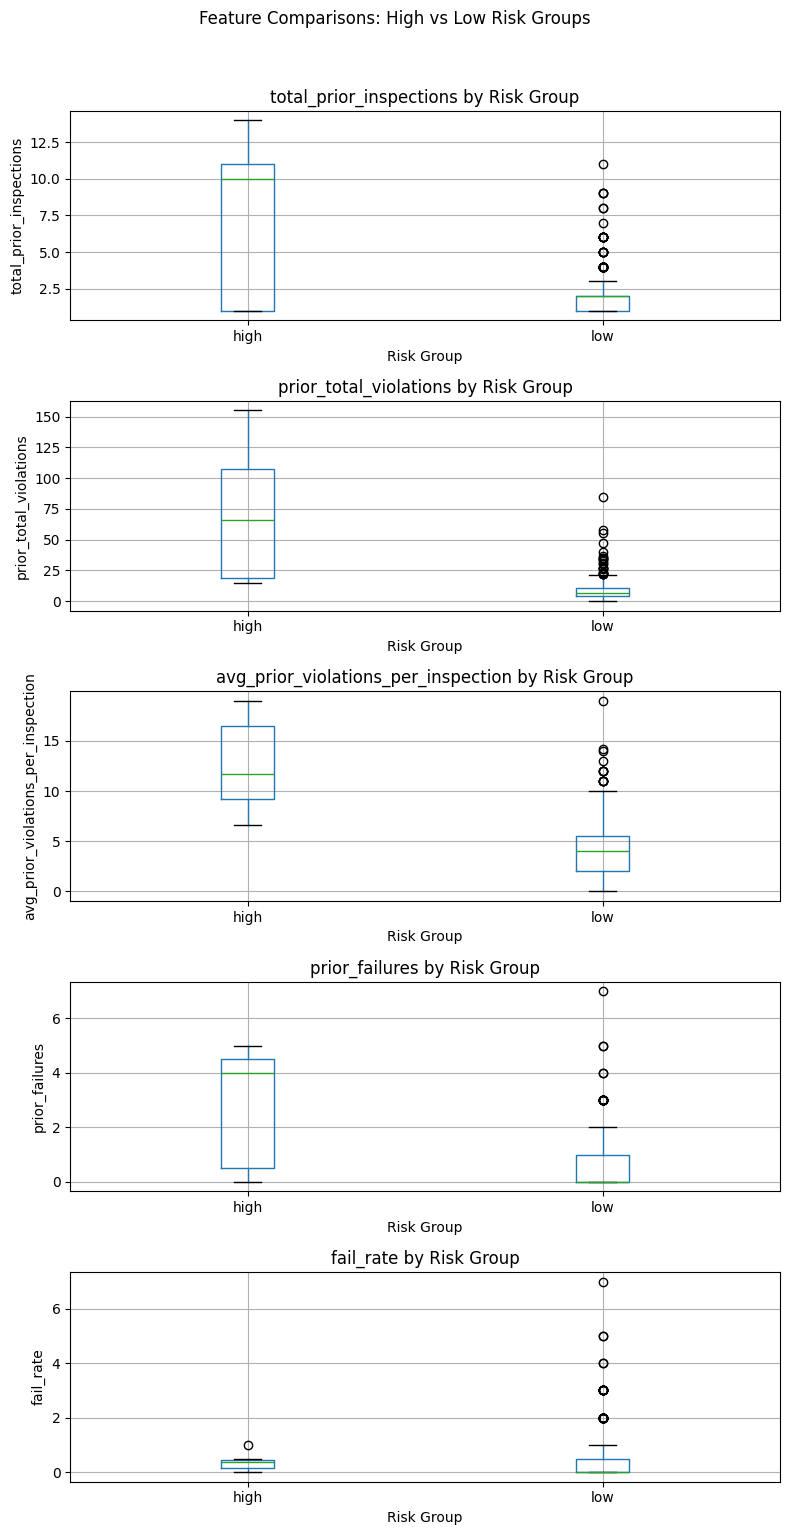

In [105]:
# === Plot Feature Differences Between High and Low Risk Groups ===

import matplotlib.pyplot as plt

# Features you want to plot
features_to_plot = [
    'total_prior_inspections',
    'prior_total_violations',
    'avg_prior_violations_per_inspection',
    'prior_failures',
    'fail_rate'
]

# Create subplots
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, figsize=(8, len(features_to_plot)*3))

for idx, feature in enumerate(features_to_plot):
    compare_df.boxplot(column=feature, by='risk_group', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Risk Group')
    axes[idx].set_ylabel(feature)
    axes[idx].set_xlabel('Risk Group')

plt.tight_layout()
plt.suptitle('Feature Comparisons: High vs Low Risk Groups', y=1.02)
plt.show()


✅ Risk zone distribution:
risk_zone
low       674
medium    235
high        7
Name: count, dtype: int64


<Axes: xlabel='risk_zone'>

Text(0.5, 1.0, 'Risk Zone Distribution')

Text(0.5, 0, 'Risk Zone')

Text(0, 0.5, 'Number of Restaurants')

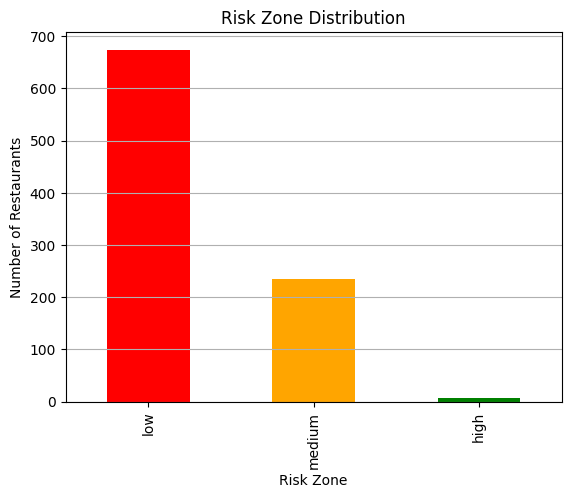


✅ Top 10 High-Risk Restaurants (by predicted failure probability):


,failure_probability,zip,risk_zone
0,0.846714,60618,high
1,0.822752,60616,high
2,0.789509,60618,high
3,0.785252,60614,high
4,0.773007,60626,high
5,0.761074,60609,high
6,0.752195,60609,high


In [107]:
# === Full Risk Scoring System: Generate Risk Scores, Assign Zones, Visualize ===

import pandas as pd
import matplotlib.pyplot as plt

# 1. Create Risk Scores Table
risk_scores = pd.DataFrame({
    'failure_probability': ensemble_probs,
    'zip': X_val['zip']
})
risk_scores = risk_scores.sort_values(by='failure_probability', ascending=False).reset_index(drop=True)

# 2. Define Risk Zones
def assign_risk_zone(prob):
    if prob >= 0.75:
        return 'high'
    elif prob >= 0.5:
        return 'medium'
    else:
        return 'low'

risk_scores['risk_zone'] = risk_scores['failure_probability'].apply(assign_risk_zone)

# 3. Print Risk Zone Distribution
print("✅ Risk zone distribution:")
print(risk_scores['risk_zone'].value_counts())

# 4. Visualize Risk Zones
risk_scores['risk_zone'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Risk Zone Distribution')
plt.xlabel('Risk Zone')
plt.ylabel('Number of Restaurants')
plt.grid(axis='y')
plt.show()

# 5. Display top risky restaurants (optional)
print("\n✅ Top 10 High-Risk Restaurants (by predicted failure probability):")
display(risk_scores[risk_scores['risk_zone'] == 'high'].head(10))


In [ ]:
# === Create Days Since Last Inspection Feature ===
# This cell calculates the number of days between each inspection and the previous inspection
# for the same restaurant (place_id).

# Ensure inspection_date is a datetime type
df['inspection_date'] = pd.to_datetime(df['inspection_date'])

# Sort again just to be 100% safe
df = df.sort_values(['place_id', 'inspection_date']).reset_index(drop=True)

# Calculate days since last inspection
df['days_since_last_inspection'] = (
    df.groupby('place_id')['inspection_date']
    .diff()
    .dt.days
)

# Fill NaNs (first inspection has no previous) with median gap
median_gap = df['days_since_last_inspection'].median()
df['days_since_last_inspection'] = df['days_since_last_inspection'].fillna(median_gap)

print("✅ Created days_since_last_inspection feature.")
df[['place_id', 'inspection_date', 'inspection_number', 'days_since_last_inspection']].head(10)


In [ ]:
# Step 2: Shift features (t-1) and labels (t+1)
df_seq["has_violation_38_t+1"] = df_seq.groupby("dba_name")["has_violation_38"].shift(-1)

# Create lagged (t-1) versions of all features you want to include
lag_cols = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]

for col in lag_cols:
    df_seq[f"{col}_t-1"] = df_seq.groupby("dba_name")[col].shift(1)

# Drop rows where t+1 or t-1 is missing
df_seq = df_seq.dropna(subset=["has_violation_38_t+1"] + [f"{col}_t-1" for col in lag_cols])

# Convert the target to int (was float from shift)
df_seq["has_violation_38_t+1"] = df_seq["has_violation_38_t+1"].astype(int)

df_seq.head()


<ipython-input-42-3080b8e63737>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq["has_violation_38_t+1"] = df_seq["has_violation_38_t+1"].astype(int)


,inspection_id,inspection_date,dba_name,zip,facility_category,inspection_type,risk,violation_count,has_violation_7,has_supervision_violation,has_violation_38,has_violation_38_t+1,zip_t-1,facility_category_t-1,inspection_type_t-1,risk_t-1,violation_count_t-1,has_violation_7_t-1,has_supervision_violation_t-1,has_violation_38_t-1
1,2568159,2022-12-07T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),2,1,0,1,1,60641,restaurant,canvass,risk 1 (high),1,0,1,0
2,2575145,2023-04-28T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),11,1,1,1,0,60641,restaurant,canvass,risk 1 (high),2,1,0,1
3,2575670,2023-05-10T00:00:00.000,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,0,0,60641,restaurant,canvass,risk 1 (high),11,1,1,1
4,2588221,2024-01-18T00:00:00.000,#1 chop suey,60641,restaurant,complaint,risk 1 (high),0,0,0,0,1,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,0
5,2612542,2025-02-21T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),6,1,0,1,0,60641,restaurant,complaint,risk 1 (high),0,0,0,0


In [ ]:
# Step 3: Define predictive features (current + lagged)
feature_cols_current = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]

feature_cols_lagged = [f"{col}_t-1" for col in feature_cols_current]

# Combine current and lagged features
X_seq = pd.get_dummies(df_seq[feature_cols_current + feature_cols_lagged], drop_first=True)
y_seq = df_seq["has_violation_38_t+1"]

X_seq.shape, y_seq.shape


((23559, 185), (23559,))

In [ ]:
from sklearn.model_selection import train_test_split

# First: train vs temp (70% train, 30% temp)
X_train_seq, X_temp_seq, y_train_seq, y_temp_seq = train_test_split(
    X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42
)

# Then: validation and test (15% each)
X_val_seq, X_test_seq, y_val_seq, y_test_seq = train_test_split(
    X_temp_seq, y_temp_seq, test_size=0.5, stratify=y_temp_seq, random_state=42
)

# Confirm sizes
print("Train size:", len(X_train_seq))
print("Validation size:", len(X_val_seq))
print("Test size:", len(X_test_seq))


Train size: 16491
Validation size: 3534
Test size: 3534


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest on temporal features
rf_seq_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_seq_model.fit(X_train_seq, y_train_seq)

# Evaluate on validation set
y_val_seq_pred = rf_seq_model.predict(X_val_seq)

print("Validation Performance — Predicting Violation 38 at Next Inspection (using two inspections):")
print(classification_report(y_val_seq, y_val_seq_pred))


Validation Performance — Predicting Violation 38 at Next Inspection (using two inspections):
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      2108
           1       0.48      0.33      0.39      1426

    accuracy                           0.58      3534
   macro avg       0.55      0.54      0.54      3534
weighted avg       0.57      0.58      0.57      3534



In [ ]:
query = """
SELECT
  inspection_id,
  inspection_date,
  dba_name,
  zip,
  facility_category,
  inspection_type,
  risk,
  violation_count,
  has_violation_1,
  has_violation_2,
  has_violation_3,
  has_violation_4,
  has_violation_6,
  has_violation_7,
  has_violation_38,
  has_supervision_violation,
  has_employee_health_violation,
  has_contamination_violation,
  has_temp_control_violation,
  has_food_source_violation,
  has_equipment_violation
FROM `hygiene-prediction-434.HygienePredictionColumn.CleanedInspectionColumn`
WHERE has_violation_38 IS NOT NULL
ORDER BY dba_name, inspection_date
"""

df_seq = client.query(query).to_dataframe()
df_seq.head()


,inspection_id,inspection_date,dba_name,zip,facility_category,inspection_type,risk,violation_count,has_violation_1,has_violation_2,...,has_violation_4,has_violation_6,has_violation_7,has_violation_38,has_supervision_violation,has_employee_health_violation,has_contamination_violation,has_temp_control_violation,has_food_source_violation,has_equipment_violation
0,2550052,2022-02-18T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2568159,2022-12-07T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),2,0,0,...,0,0,1,1,0,0,0,0,0,0
2,2575145,2023-04-28T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),11,1,0,...,0,0,1,1,1,0,0,1,1,0
3,2575670,2023-05-10T00:00:00.000,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2588221,2024-01-18T00:00:00.000,#1 chop suey,60641,restaurant,complaint,risk 1 (high),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 2: Create the "any violation at t+1" label

# Identify all columns that start with 'has_violation_' and are not t-1 lag columns
violation_cols = [
    "has_violation_1",
    "has_violation_2",
    "has_violation_3",
    "has_violation_4",
    "has_violation_6",
    "has_violation_7",
    "has_violation_38",
    "has_supervision_violation",
    "has_employee_health_violation",
    "has_contamination_violation",
    "has_temp_control_violation",
    "has_food_source_violation",
    "has_equipment_violation"
]

# Shift all violation columns by -1 to get t+1 violations
df_seq["has_any_violation_t+1"] = (
    df_seq.groupby("dba_name")[violation_cols]
    .transform(lambda x: x.shift(-1).fillna(0).astype(int))
    .any(axis=1)
).astype(int)

# Show preview
df_seq[["dba_name", "inspection_date", "has_any_violation_t+1"] + violation_cols].head()


,dba_name,inspection_date,has_any_violation_t+1,has_violation_1,has_violation_2,has_violation_3,has_violation_4,has_violation_6,has_violation_7,has_violation_38,has_supervision_violation,has_employee_health_violation,has_contamination_violation,has_temp_control_violation,has_food_source_violation,has_equipment_violation
0,#1 chop suey,2022-02-18T00:00:00.000,1,0,1,0,0,0,0,0,1,0,0,0,0,0
1,#1 chop suey,2022-12-07T00:00:00.000,1,0,0,0,0,0,1,1,0,0,0,0,0,0
2,#1 chop suey,2023-04-28T00:00:00.000,1,1,0,0,0,0,1,1,1,0,0,1,1,0
3,#1 chop suey,2023-05-10T00:00:00.000,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,#1 chop suey,2024-01-18T00:00:00.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 3: Create t–1 features for inspection context and violations
lag_cols = [
    "zip",
    "facility_category",
    "inspection_type",
    "risk",
    "violation_count",
    "has_violation_7",
    "has_supervision_violation",
    "has_violation_38"
]

# Create lagged (t–1) versions of selected features
for col in lag_cols:
    df_seq[f"{col}_t-1"] = df_seq.groupby("dba_name")[col].shift(1)

# Drop rows where t+1 label is missing or t–1 features are missing
df_seq = df_seq.dropna(subset=["has_any_violation_t+1"] + [f"{col}_t-1" for col in lag_cols])

# Convert label to int (in case it's float)
df_seq["has_any_violation_t+1"] = df_seq["has_any_violation_t+1"].astype(int)

df_seq.head()


<ipython-input-49-60229a86ad57>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq["has_any_violation_t+1"] = df_seq["has_any_violation_t+1"].astype(int)


,inspection_id,inspection_date,dba_name,zip,facility_category,inspection_type,risk,violation_count,has_violation_1,has_violation_2,...,has_equipment_violation,has_any_violation_t+1,zip_t-1,facility_category_t-1,inspection_type_t-1,risk_t-1,violation_count_t-1,has_violation_7_t-1,has_supervision_violation_t-1,has_violation_38_t-1
1,2568159,2022-12-07T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),2,0,0,...,0,1,60641,restaurant,canvass,risk 1 (high),1,0,1,0
2,2575145,2023-04-28T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),11,1,0,...,0,1,60641,restaurant,canvass,risk 1 (high),2,1,0,1
3,2575670,2023-05-10T00:00:00.000,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,...,0,0,60641,restaurant,canvass,risk 1 (high),11,1,1,1
4,2588221,2024-01-18T00:00:00.000,#1 chop suey,60641,restaurant,complaint,risk 1 (high),0,0,0,...,0,1,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,0
5,2612542,2025-02-21T00:00:00.000,#1 chop suey,60641,restaurant,canvass,risk 1 (high),6,0,0,...,1,1,60641,restaurant,complaint,risk 1 (high),0,0,0,0


In [ ]:
# Step 4: Define full feature list (current + lagged)
feature_cols_current = [
    "zip",
    "facility_category",
    "inspection_type",
    "risk",
    "violation_count",
    "has_violation_7",
    "has_supervision_violation",
    "has_violation_38"
]

feature_cols_lagged = [f"{col}_t-1" for col in feature_cols_current]

# Build feature matrix (X) and target (y)
X = pd.get_dummies(df_seq[feature_cols_current + feature_cols_lagged], drop_first=True)
y = df_seq["has_any_violation_t+1"]

# Confirm shape
X.shape, y.shape


((32817, 189), (32817,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Confirm sizes
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 22971
Validation size: 4923
Test size: 4923


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate
print("Validation Performance — Predicting Any Violation at Next Inspection:")
print(classification_report(y_val, y_val_pred))


Validation Performance — Predicting Any Violation at Next Inspection:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62      2539
           1       0.59      0.56      0.57      2384

    accuracy                           0.60      4923
   macro avg       0.60      0.59      0.59      4923
weighted avg       0.60      0.60      0.60      4923



In [ ]:
# Ensure inspection_date is datetime
df_seq["inspection_date"] = pd.to_datetime(df_seq["inspection_date"])

# Group by facility and calculate days since last inspection
df_seq["days_since_last"] = (
    df_seq.groupby("dba_name")["inspection_date"]
    .diff()
    .dt.days
)

# Drop rows where lagged features or labels are still missing
df_seq = df_seq.dropna(subset=[
    "has_any_violation_t+1",
    "days_since_last"
] + [f"{col}_t-1" for col in lag_cols])


In [ ]:
# Step 2: Compute change in violation count
df_seq["violation_count_diff"] = (
    df_seq["violation_count"] - df_seq["violation_count_t-1"]
)


In [ ]:
# Step 3: Update the full feature list
feature_cols_current = [
    "zip",
    "facility_category",
    "inspection_type",
    "risk",
    "violation_count",
    "has_violation_7",
    "has_supervision_violation",
    "has_violation_38"
]

feature_cols_lagged = [f"{col}_t-1" for col in feature_cols_current]

# Include engineered features
engineered_cols = ["days_since_last", "violation_count_diff"]

# Build feature matrix and target
X = pd.get_dummies(df_seq[feature_cols_current + feature_cols_lagged + engineered_cols], drop_first=True)
y = df_seq["has_any_violation_t+1"]

# Confirm shape
X.shape, y.shape


((23559, 186), (23559,))

In [ ]:
from sklearn.model_selection import train_test_split

# Redo the split using updated feature matrix
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 16491
Validation size: 3534
Test size: 3534


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Retrain the Random Forest with the improved features
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate
print("Validation Performance — Improved Model (Any Violation at Next Inspection):")
print(classification_report(y_val, y_val_pred))


Validation Performance — Improved Model (Any Violation at Next Inspection):
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      1842
           1       0.59      0.59      0.59      1692

    accuracy                           0.61      3534
   macro avg       0.61      0.61      0.61      3534
weighted avg       0.61      0.61      0.61      3534



In [ ]:
!pip install xgboost --quiet


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Step 2: Train XGBoost on the improved feature set
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate performance
print("Validation Performance — XGBoost Model (Any Violation at Next Inspection):")
print(classification_report(y_val, y_val_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance — XGBoost Model (Any Violation at Next Inspection):
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1842
           1       0.61      0.65      0.63      1692

    accuracy                           0.64      3534
   macro avg       0.64      0.64      0.64      3534
weighted avg       0.64      0.64      0.64      3534



In [ ]:
query = """
SELECT
  inspection_id,
  inspection_date,
  dba_name,
  zip,
  facility_category,
  inspection_type,
  risk,
  violation_count,
  has_violation_1,
  has_violation_2,
  has_violation_3,
  has_violation_4,
  has_violation_6,
  has_violation_7,
  has_violation_38,
  has_supervision_violation,
  has_employee_health_violation,
  has_contamination_violation,
  has_temp_control_violation,
  has_food_source_violation,
  has_equipment_violation
FROM `hygiene-prediction-434.HygienePredictionColumn.CleanedInspectionColumn`
WHERE has_violation_38 IS NOT NULL
ORDER BY dba_name, inspection_date
"""

df_seq = client.query(query).to_dataframe()
df_seq["inspection_date"] = pd.to_datetime(df_seq["inspection_date"])
df_seq.head()


,inspection_id,inspection_date,dba_name,zip,facility_category,inspection_type,risk,violation_count,has_violation_1,has_violation_2,...,has_violation_4,has_violation_6,has_violation_7,has_violation_38,has_supervision_violation,has_employee_health_violation,has_contamination_violation,has_temp_control_violation,has_food_source_violation,has_equipment_violation
0,2550052,2022-02-18,#1 chop suey,60641,restaurant,canvass,risk 1 (high),1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2568159,2022-12-07,#1 chop suey,60641,restaurant,canvass,risk 1 (high),2,0,0,...,0,0,1,1,0,0,0,0,0,0
2,2575145,2023-04-28,#1 chop suey,60641,restaurant,canvass,risk 1 (high),11,1,0,...,0,0,1,1,1,0,0,1,1,0
3,2575670,2023-05-10,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2588221,2024-01-18,#1 chop suey,60641,restaurant,complaint,risk 1 (high),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 2: Create t+1 label — "any violation occurs at next inspection"
violation_cols = [
    "has_violation_1",
    "has_violation_2",
    "has_violation_3",
    "has_violation_4",
    "has_violation_6",
    "has_violation_7",
    "has_violation_38",
    "has_supervision_violation",
    "has_employee_health_violation",
    "has_contamination_violation",
    "has_temp_control_violation",
    "has_food_source_violation",
    "has_equipment_violation"
]

df_seq["has_any_violation_t+1"] = (
    df_seq.groupby("dba_name")[violation_cols]
    .transform(lambda x: x.shift(-1).fillna(0).astype(int))
    .any(axis=1)
).astype(int)


In [ ]:
# Step 3: Define base features to lag
base_features = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count",
    "has_violation_7", "has_supervision_violation", "has_violation_38"
]

# Create lagged features for t-1 and t-2
for col in base_features:
    df_seq[f"{col}_t-1"] = df_seq.groupby("dba_name")[col].shift(1)
    df_seq[f"{col}_t-2"] = df_seq.groupby("dba_name")[col].shift(2)

# Create days since last and since second-last inspections
df_seq["days_since_t-1"] = df_seq.groupby("dba_name")["inspection_date"].diff().dt.days
df_seq["days_since_t-2"] = df_seq.groupby("dba_name")["inspection_date"].diff(2).dt.days

# Drop any rows missing t+1 label or lagged features
lag_cols = [f"{col}_t-1" for col in base_features] + [f"{col}_t-2" for col in base_features]
df_seq = df_seq.dropna(subset=["has_any_violation_t+1", "days_since_t-1", "days_since_t-2"] + lag_cols)

# Convert label to int (if needed)
df_seq["has_any_violation_t+1"] = df_seq["has_any_violation_t+1"].astype(int)

df_seq.head()


<ipython-input-62-37a7a471581b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq["has_any_violation_t+1"] = df_seq["has_any_violation_t+1"].astype(int)


,inspection_id,inspection_date,dba_name,zip,facility_category,inspection_type,risk,violation_count,has_violation_1,has_violation_2,...,violation_count_t-1,violation_count_t-2,has_violation_7_t-1,has_violation_7_t-2,has_supervision_violation_t-1,has_supervision_violation_t-2,has_violation_38_t-1,has_violation_38_t-2,days_since_t-1,days_since_t-2
2,2575145,2023-04-28,#1 chop suey,60641,restaurant,canvass,risk 1 (high),11,1,0,...,2,1,1,0,0,1,1,0,142.0,434.0
3,2575670,2023-05-10,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),1,0,0,...,11,2,1,1,1,0,1,1,12.0,154.0
4,2588221,2024-01-18,#1 chop suey,60641,restaurant,complaint,risk 1 (high),0,0,0,...,1,11,0,1,0,1,0,1,253.0,265.0
5,2612542,2025-02-21,#1 chop suey,60641,restaurant,canvass,risk 1 (high),6,0,0,...,0,1,0,0,0,0,0,0,400.0,653.0
6,2612794,2025-02-26,#1 chop suey,60641,restaurant,canvass re inspection,risk 1 (high),3,0,1,...,6,0,1,0,0,0,1,0,5.0,405.0


In [ ]:
# Step 4: Define feature columns
feature_cols_current = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count",
    "has_violation_7", "has_supervision_violation", "has_violation_38"
]

feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = ["days_since_t-1", "days_since_t-2"]

# Combine all features
X = pd.get_dummies(
    df_seq[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y = df_seq["has_any_violation_t+1"]

# Confirm shape
X.shape, y.shape


((23559, 279), (23559,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 16491
Validation size: 3534
Test size: 3534


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define base XGBoost model
xgb_base = xgb.XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Run grid search
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Show best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
from sklearn.metrics import classification_report

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict on validation set
y_val_pred = best_model.predict(X_val)

# Evaluate
print("Validation Performance — Tuned XGBoost Model:")
print(classification_report(y_val, y_val_pred))


Validation Performance — Tuned XGBoost Model:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1842
           1       0.61      0.66      0.63      1692

    accuracy                           0.63      3534
   macro avg       0.63      0.63      0.63      3534
weighted avg       0.63      0.63      0.63      3534



In [ ]:
from sklearn.metrics import classification_report

# Final test set prediction
y_test_pred = best_model.predict(X_test)

# Evaluate performance on test set
print("Test Performance — Tuned XGBoost Model (Any Violation at Next Inspection):")
print(classification_report(y_test, y_test_pred))


Test Performance — Tuned XGBoost Model (Any Violation at Next Inspection):
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1842
           1       0.61      0.67      0.64      1692

    accuracy                           0.64      3534
   macro avg       0.64      0.64      0.64      3534
weighted avg       0.64      0.64      0.64      3534



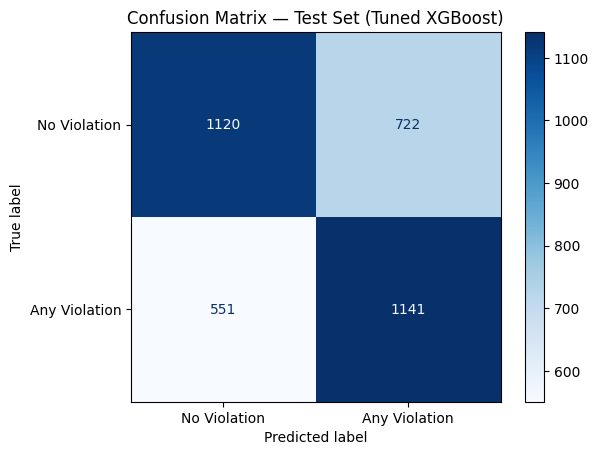

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Violation", "Any Violation"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set (Tuned XGBoost)")
plt.show()


In [ ]:
# Step 1: Filter to restaurant facilities only
df_rest = df_seq[df_seq["facility_category"] == "restaurant"].copy()

print("Filtered rows (restaurant only):", len(df_rest))


Filtered rows (restaurant only): 17401


In [ ]:
# Define the same feature structure
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count",
    "has_violation_7", "has_supervision_violation", "has_violation_38"
]

feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = ["days_since_t-1", "days_since_t-2", "violation_count_diff"]

# Recompute violation_count_diff after filtering
df_rest["violation_count_diff"] = (
    df_rest["violation_count"] - df_rest["violation_count_t-1"]
)

# Build feature matrix for restaurants
X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_any_violation_t+1"]

# Confirm shape
X_rest.shape, y_rest.shape


((17401, 228), (17401,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split restaurant-only data
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=42
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=42
)

print("Restaurant Train size:", len(X_rest_train))
print("Restaurant Validation size:", len(X_rest_val))
print("Restaurant Test size:", len(X_rest_test))


Restaurant Train size: 12180
Restaurant Validation size: 2610
Restaurant Test size: 2611


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Train the restaurant-focused XGBoost model
xgb_rest = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_rest_train == 0).sum() / (y_rest_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb_rest.fit(X_rest_train, y_rest_train)

# Evaluate on validation set
y_rest_val_pred = xgb_rest.predict(X_rest_val)

print("Validation Performance — XGBoost (Restaurants Only):")
print(classification_report(y_rest_val, y_rest_val_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance — XGBoost (Restaurants Only):
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1328
           1       0.61      0.67      0.64      1282

    accuracy                           0.63      2610
   macro avg       0.63      0.63      0.63      2610
weighted avg       0.63      0.63      0.63      2610



In [ ]:
# Predict on restaurant test set
y_rest_test_pred = xgb_rest.predict(X_rest_test)

# Evaluate performance
print("Test Performance — XGBoost (Restaurants Only):")
print(classification_report(y_rest_test, y_rest_test_pred))


Test Performance — XGBoost (Restaurants Only):
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1328
           1       0.61      0.68      0.64      1283

    accuracy                           0.63      2611
   macro avg       0.63      0.63      0.63      2611
weighted avg       0.63      0.63      0.63      2611



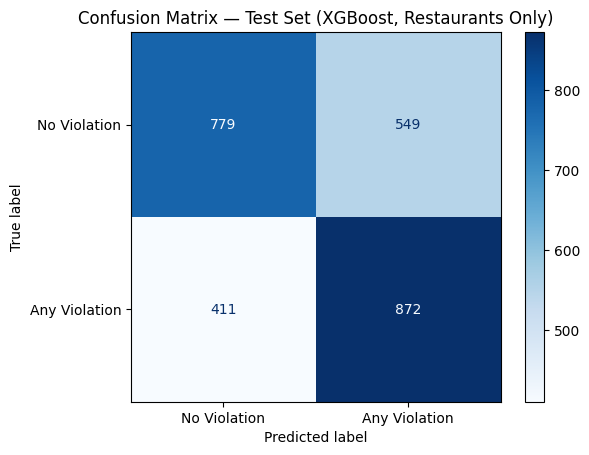

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create and display confusion matrix
cm_rest = confusion_matrix(y_rest_test, y_rest_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rest,
    display_labels=["No Violation", "Any Violation"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set (XGBoost, Restaurants Only)")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Create a DataFrame from the test set predictions
results_df = pd.DataFrame({
    "y_true": y_rest_test.values,
    "y_pred": y_rest_test_pred,
}, index=X_rest_test.index)

# Label prediction result type
conditions = [
    (results_df.y_true == 1) & (results_df.y_pred == 1),
    (results_df.y_true == 0) & (results_df.y_pred == 0),
    (results_df.y_true == 1) & (results_df.y_pred == 0),
    (results_df.y_true == 0) & (results_df.y_pred == 1),
]
labels = ["TP", "TN", "FN", "FP"]

results_df["classification"] = np.select(conditions, labels, default="Unknown")


# Merge with original restaurant inspection data
df_misclass = df_rest.loc[results_df.index].copy()
df_misclass["classification"] = results_df["classification"]

# Preview results
df_misclass[["dba_name", "inspection_date", "classification", "has_any_violation_t+1"]].head()


,dba_name,inspection_date,classification,has_any_violation_t+1
39057,"taqueria el potosi,inc.",2025-03-07,TN,0
11029,dunkin donuts,2022-06-13,TN,0
15185,"golden hook fish, chicken",2021-08-24,TP,1
26895,mr. submarine,2024-01-12,FP,0
32271,red snapper fish chicken & pizza,2021-10-19,FP,0


In [ ]:
# Step 2: Group by classification label and compute feature averages
group_summary = df_misclass.groupby("classification")[
    ["violation_count", "days_since_t-1", "days_since_t-2"]
].mean().round(2)

print("Average feature values by classification group:")
group_summary


Average feature values by classification group:


,violation_count,days_since_t-1,days_since_t-2
classification,,,
FN,1.42,202.23,429.10
FP,5.18,101.25,192.59
TN,1.2,254.45,521.29
TP,6.85,101.69,190.11


<ipython-input-79-6baf8c31065f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-79-6baf8c31065f>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-79-6baf8c31065f>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


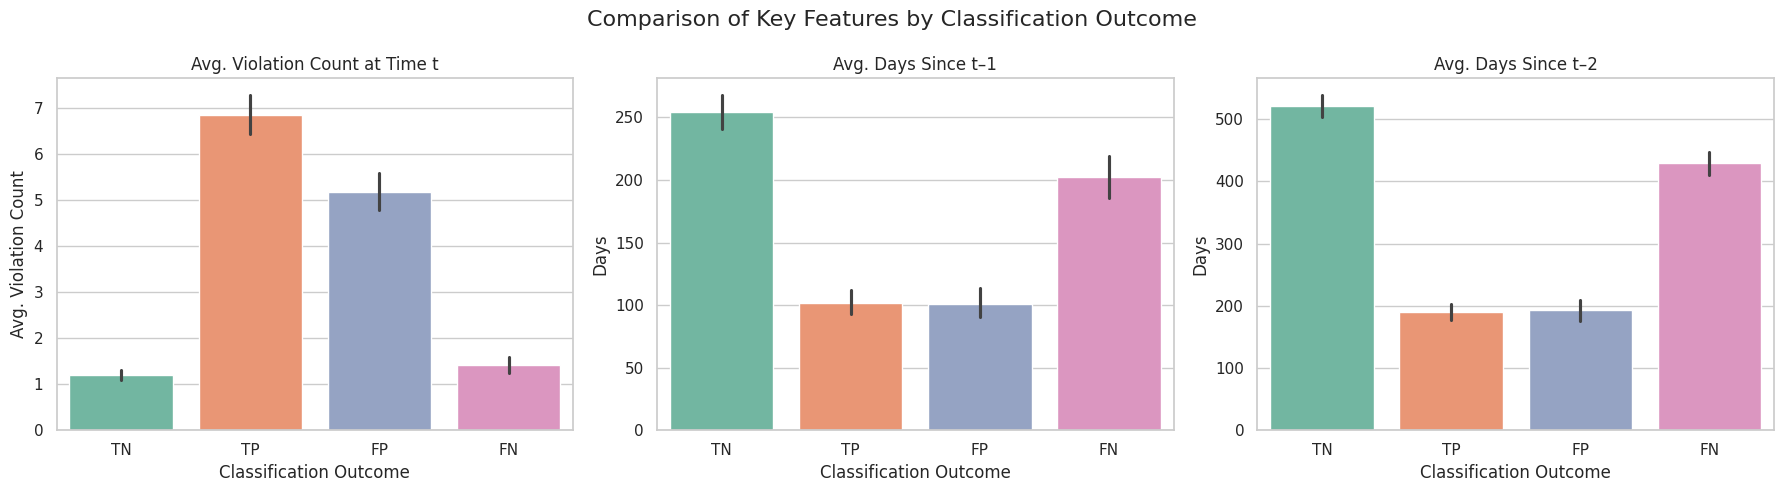

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Barplot for each feature by classification group
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Violation count
sns.barplot(
    data=df_misclass,
    x="classification",
    y="violation_count",
    ax=axes[0],
    palette="Set2"
)
axes[0].set_title("Avg. Violation Count at Time t")
axes[0].set_ylabel("Avg. Violation Count")
axes[0].set_xlabel("Classification Outcome")

# Plot 2: Days since last inspection
sns.barplot(
    data=df_misclass,
    x="classification",
    y="days_since_t-1",
    ax=axes[1],
    palette="Set2"
)
axes[1].set_title("Avg. Days Since t–1")
axes[1].set_ylabel("Days")
axes[1].set_xlabel("Classification Outcome")

# Plot 3: Days since second-last inspection
sns.barplot(
    data=df_misclass,
    x="classification",
    y="days_since_t-2",
    ax=axes[2],
    palette="Set2"
)
axes[2].set_title("Avg. Days Since t–2")
axes[2].set_ylabel("Days")
axes[2].set_xlabel("Classification Outcome")

plt.suptitle("Comparison of Key Features by Classification Outcome", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Extract month and season
df_rest["month"] = df_rest["inspection_date"].dt.month

# Map month to season (simplified US version)
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

df_rest["season"] = df_rest["month"].apply(get_season)

df_rest[["inspection_date", "month", "season"]].head()


,inspection_date,month,season
2,2023-04-28,4,spring
3,2023-05-10,5,spring
4,2024-01-18,1,winter
5,2025-02-21,2,winter
6,2025-02-26,2,winter


In [ ]:
# Step 2: Flag complaint-driven inspections (case-insensitive)
df_rest["is_complaint"] = df_rest["inspection_type"].str.contains("complaint", case=False, na=False).astype(int)
df_rest["is_reinspection"] = df_rest["inspection_type"].str.contains("re-inspection|reinspection", case=False, na=False).astype(int)

# Preview
df_rest[["inspection_type", "is_complaint", "is_reinspection"]].head()


,inspection_type,is_complaint,is_reinspection
2,canvass,0,0
3,canvass re inspection,0,0
4,complaint,1,0
5,canvass,0,0
6,canvass re inspection,0,0


In [ ]:
# Step 3: Rebuild feature matrix with seasonality + complaint flags

# Redefine feature columns
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count",
    "has_violation_7", "has_supervision_violation", "has_violation_38"
]

feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = [
    "days_since_t-1", "days_since_t-2", "violation_count_diff",
    "month", "season", "is_complaint", "is_reinspection"
]

# Rebuild X and y
X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_any_violation_t+1"]

# Confirm shape
X_rest.shape, y_rest.shape


((17401, 234), (17401,))

In [ ]:
from sklearn.model_selection import train_test_split

# Re-split restaurant data with updated features
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=42
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=42
)

print("Train size:", len(X_rest_train))
print("Validation size:", len(X_rest_val))
print("Test size:", len(X_rest_test))


Train size: 12180
Validation size: 2610
Test size: 2611


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Retrain XGBoost with additional features
xgb_rest = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest_train == 0).sum() / (y_rest_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb_rest.fit(X_rest_train, y_rest_train)

# Predict on validation set
y_rest_val_pred = xgb_rest.predict(X_rest_val)

# Evaluate performance
print("Validation Performance — XGBoost (Restaurants with Seasonality + Complaint Flags):")
print(classification_report(y_rest_val, y_rest_val_pred))


Validation Performance — XGBoost (Restaurants with Seasonality + Complaint Flags):
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1328
           1       0.61      0.68      0.64      1282

    accuracy                           0.63      2610
   macro avg       0.63      0.63      0.63      2610
weighted avg       0.63      0.63      0.63      2610



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train logistic regression with class balancing
log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_model.fit(X_rest_train, y_rest_train)

# Predict and evaluate
y_rest_val_pred_log = log_model.predict(X_rest_val)

print("Validation Performance — Logistic Regression (Restaurants Only):")
print(classification_report(y_rest_val, y_rest_val_pred_log))


Validation Performance — Logistic Regression (Restaurants Only):
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1328
           1       0.61      0.62      0.62      1282

    accuracy                           0.62      2610
   macro avg       0.62      0.62      0.62      2610
weighted avg       0.62      0.62      0.62      2610



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
!pip install lightgbm --quiet


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Create the LightGBM model
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Fit the model
lgb_model.fit(X_rest_train, y_rest_train)

# Predict on validation set
y_rest_val_pred_lgb = lgb_model.predict(X_rest_val)

# Evaluate
print("Validation Performance — LightGBM (Restaurants Only):")
print(classification_report(y_rest_val, y_rest_val_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5983, number of negative: 6197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 12180, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
# Step 1: Compute zip-level violation rates using all of df_rest (including non-test examples)
zip_violation_rate = df_rest.groupby("zip")["has_any_violation_t+1"].mean()

# Add as a new column to df_rest
df_rest["zip_violation_rate"] = df_rest["zip"].map(zip_violation_rate)

# Preview
df_rest[["zip", "zip_violation_rate"]].head()


,zip,zip_violation_rate
2,60641,0.516949
3,60641,0.516949
4,60641,0.516949
5,60641,0.516949
6,60641,0.516949


In [ ]:
# Step 2: Rebuild X and y with zip_violation_rate included

# Redefine all features
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count",
    "has_violation_7", "has_supervision_violation", "has_violation_38"
]

feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = [
    "days_since_t-1", "days_since_t-2", "violation_count_diff",
    "month", "season", "is_complaint", "is_reinspection",
    "zip_violation_rate"  # 👈 NEW
]

# Create the updated feature matrix
X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_any_violation_t+1"]

# Confirm shape
X_rest.shape, y_rest.shape


((17401, 235), (17401,))

In [ ]:
from sklearn.model_selection import train_test_split

# Re-split using updated feature matrix
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=42
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=42
)

print("Train size:", len(X_rest_train))
print("Validation size:", len(X_rest_val))
print("Test size:", len(X_rest_test))


Train size: 12180
Validation size: 2610
Test size: 2611


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Retrain XGBoost with ZIP-level risk included
xgb_rest = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest_train == 0).sum() / (y_rest_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb_rest.fit(X_rest_train, y_rest_train)

# Predict on validation set
y_rest_val_pred = xgb_rest.predict(X_rest_val)

# Evaluate
print("Validation Performance — XGBoost (with zip_violation_rate):")
print(classification_report(y_rest_val, y_rest_val_pred))


Validation Performance — XGBoost (with zip_violation_rate):
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      1328
           1       0.62      0.67      0.64      1282

    accuracy                           0.63      2610
   macro avg       0.64      0.64      0.63      2610
weighted avg       0.64      0.63      0.63      2610



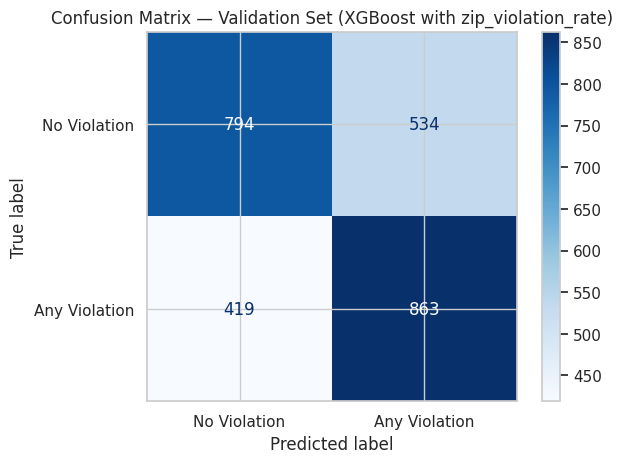

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_rest_val, y_rest_val_pred)

# Display it
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Violation", "Any Violation"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Validation Set (XGBoost with zip_violation_rate)")
plt.show()


In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project="hygiene-prediction-434")


In [ ]:
# Google Cloud + BigQuery
from google.colab import auth
from google.cloud import bigquery
from google.cloud import storage

# Data handling
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Tree-based models
import xgboost as xgb
import lightgbm as lgb

# Metrics & evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# MLP (you'll use this soon)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [ ]:
# Load from BigQuery
query = """
SELECT
  inspection_id,
  inspection_date,
  dba_name,
  zip,
  facility_category,
  inspection_type,
  risk,
  violation_count,
  has_violation_1,
  has_violation_2,
  has_violation_3,
  has_violation_4,
  has_violation_6,
  has_violation_7,
  has_violation_38,
  has_supervision_violation,
  has_employee_health_violation,
  has_contamination_violation,
  has_temp_control_violation,
  has_food_source_violation,
  has_equipment_violation
FROM `hygiene-prediction-434.HygienePredictionColumn.CleanedInspectionColumn`
WHERE has_violation_38 IS NOT NULL
ORDER BY dba_name, inspection_date
"""

df_seq = client.query(query).to_dataframe()
df_seq["inspection_date"] = pd.to_datetime(df_seq["inspection_date"])

# Create t+1 target
violation_cols = [col for col in df_seq.columns if col.startswith("has_violation_")]
df_seq["has_any_violation_t+1"] = (
    df_seq.groupby("dba_name")[violation_cols]
    .transform(lambda x: x.shift(-1).fillna(0).astype(int))
    .any(axis=1)
).astype(int)

# Create lagged features
base_features = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]

for col in base_features:
    df_seq[f"{col}_t-1"] = df_seq.groupby("dba_name")[col].shift(1)
    df_seq[f"{col}_t-2"] = df_seq.groupby("dba_name")[col].shift(2)

# Time between inspections
df_seq["days_since_t-1"] = df_seq.groupby("dba_name")["inspection_date"].diff().dt.days
df_seq["days_since_t-2"] = df_seq.groupby("dba_name")["inspection_date"].diff(2).dt.days

# Add violation delta
df_seq["violation_count_diff"] = df_seq["violation_count"] - df_seq["violation_count_t-1"]

# Add month and season
df_seq["month"] = df_seq["inspection_date"].dt.month
df_seq["season"] = df_seq["month"].map({12:"winter", 1:"winter", 2:"winter",
                                        3:"spring", 4:"spring", 5:"spring",
                                        6:"summer", 7:"summer", 8:"summer",
                                        9:"fall", 10:"fall", 11:"fall"})

# Complaint-based inspection flags
df_seq["is_complaint"] = df_seq["inspection_type"].str.contains("complaint", case=False, na=False).astype(int)
df_seq["is_reinspection"] = df_seq["inspection_type"].str.contains("re[- ]?inspection", case=False, na=False).astype(int)

# Filter for restaurants and drop missing
df_rest = df_seq[df_seq["facility_category"] == "restaurant"].copy()
lag_cols = [f"{col}_t-1" for col in base_features] + [f"{col}_t-2" for col in base_features]
df_rest = df_rest.dropna(subset=["has_any_violation_t+1", "days_since_t-1", "days_since_t-2", "violation_count_diff"] + lag_cols)


In [ ]:
# Compute ZIP-level violation rate and merge it
zip_violation_rate = df_rest.groupby("zip")["has_any_violation_t+1"].mean()
df_rest["zip_violation_rate"] = df_rest["zip"].map(zip_violation_rate)

# Build X and y
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]
feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = [
    "days_since_t-1", "days_since_t-2", "violation_count_diff",
    "month", "season", "is_complaint", "is_reinspection", "zip_violation_rate"
]

X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_any_violation_t+1"]

X_rest.shape, y_rest.shape


((17401, 235), (17401,))

In [ ]:
# Step 1: Split and scale data for MLP

# Train/val/test split
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=42
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=42
)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_rest_train_scaled = scaler.fit_transform(X_rest_train)
X_rest_val_scaled = scaler.transform(X_rest_val)
X_rest_test_scaled = scaler.transform(X_rest_test)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize input features
scaler = StandardScaler()
X_rest_train_scaled = scaler.fit_transform(X_rest_train)
X_rest_val_scaled = scaler.transform(X_rest_val)
X_rest_test_scaled = scaler.transform(X_rest_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 2: Build the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_rest_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,529 (150.50 KB)

 Trainable params: 38,529 (150.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mlp_model.fit(
    X_rest_train_scaled, y_rest_train,
    validation_data=(X_rest_val_scaled, y_rest_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1  # 👈 this shows live training progress
)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5522 - loss: 0.7535 - val_accuracy: 0.6184 - val_loss: 0.6486
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6172 - loss: 0.6540 - val_accuracy: 0.6249 - val_loss: 0.6434
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6406 - loss: 0.6338 - val_accuracy: 0.6268 - val_loss: 0.6433
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6499 - loss: 0.6276 - val_accuracy: 0.6360 - val_loss: 0.6409
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6489 - loss: 0.6180 - val_accuracy: 0.6245 - val_loss: 0.6409
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6653 - loss: 0.6062 - val_accuracy: 0.6261 - val_loss: 0.6448
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6708 - loss: 0.5984 - val_accuracy: 0.6307 - val_loss: 0.6422
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6725 - loss: 0.5990 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report

y_val_mlp_pred = (mlp_model.predict(X_rest_val_scaled) > 0.5).astype(int)
print("Validation Performance — MLP:")
print(classification_report(y_rest_val, y_val_mlp_pred))


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Validation Performance — MLP:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1331
           1       0.62      0.62      0.62      1279

    accuracy                           0.62      2610
   macro avg       0.62      0.62      0.62      2610
weighted avg       0.62      0.62      0.62      2610



In [ ]:
query = """
SELECT *
FROM `hygiene-prediction-434.HygienePredictionRow.violation_code_sheet`
LIMIT 1000
"""

violation_code_df = client.query(query).to_dataframe()
violation_code_df


,code,description
0,1,"Person in charge present, demonstrates knowled..."
1,2,City of Chicago Food Service Sanitation Certif...
2,3,"Management, food employee and conditional empl..."
3,4,Proper use of restriction and exclusion
4,5,Procedures for responding to vomiting and diar...
...,...,...
58,59,Previous priority foundation violation corrected
59,60,Previous core violation corrected
60,61,Summary Report displayed and visible to the pu...
61,62,Compliance with Clean Indoor Air Ordinance


## 🧪 Modeling Critical Violations by Facility Type (e.g., Schools)

This section loads inspection data, identifies critical violations (codes 1–24), generates lagged and time-aware features, and trains an XGBoost model to predict whether a facility will receive a critical violation at its next inspection.

Key components:
- Authentication and data query from BigQuery
- Definition of `has_critical_violation_t+1` target label
- Feature engineering: lagged inspections, time gaps, zip-level risk
- Facility-type filtering (e.g., `FACILITY_CATEGORY = "school"`)
- Train/validation/test split and model training
- Evaluation using classification report and 5-fold cross-validation with balanced accuracy


Train size: 1344
Validation size: 288
Test size: 288

Validation Performance — XGBoost (Critical Violations Only):
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       156
           1       0.71      0.68      0.70       132

    accuracy                           0.73       288
   macro avg       0.73      0.73      0.73       288
weighted avg       0.73      0.73      0.73       288

Balanced Accuracy Scores: [0.694 0.647 0.69  0.695 0.689]
Mean Balanced Accuracy: 0.683


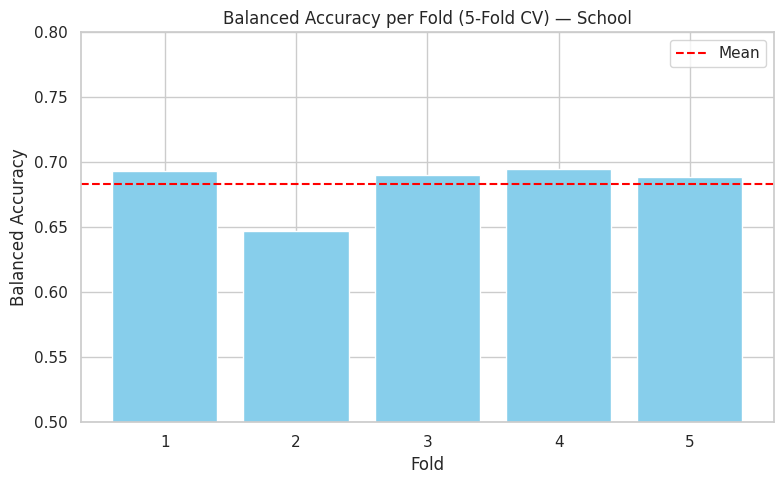

In [ ]:
from IPython.display import display

# Authenticate (if needed)
from google.colab import auth
auth.authenticate_user()

# Reconnect to BigQuery
from google.cloud import bigquery
client = bigquery.Client(project="hygiene-prediction-434")

# Run query to get full inspection history with violation codes
query = """
SELECT
  inspection_id,
  inspection_date,
  dba_name,
  zip,
  facility_category,
  inspection_type,
  risk,
  violation_count,
  violation_codes,  -- needed for critical label
  has_violation_1,
  has_violation_2,
  has_violation_3,
  has_violation_4,
  has_violation_6,
  has_violation_7,
  has_violation_38,
  has_supervision_violation,
  has_employee_health_violation,
  has_contamination_violation,
  has_temp_control_violation,
  has_food_source_violation,
  has_equipment_violation
FROM `hygiene-prediction-434.HygienePredictionColumn.CleanedInspectionColumn`
WHERE has_violation_38 IS NOT NULL
ORDER BY dba_name, inspection_date
"""

# Load data
df_seq = client.query(query).to_dataframe()
df_seq["inspection_date"] = pd.to_datetime(df_seq["inspection_date"])

df_seq["facility_category"].value_counts().sort_values(ascending=False)


# Step 1: Identify critical violation codes (1–24)
critical_codes = set(range(1, 25))  # Codes 1 through 24

def extract_codes(v):
    """Extract integer codes from nested {'list': [{'element': X}]} structure"""
    if isinstance(v, dict) and "list" in v:
        return [int(item["element"]) for item in v["list"] if "element" in item]
    return []

def has_critical_violation(v):
    """Return 1 if any code is a critical violation"""
    codes = extract_codes(v)
    return int(any(code in critical_codes for code in codes))

# Generate t+1 violation codes column
df_seq["violation_codes_t+1"] = df_seq.groupby("dba_name")["violation_codes"].shift(-1)

# Create the binary critical label
df_seq["has_critical_violation_t+1"] = df_seq["violation_codes_t+1"].apply(has_critical_violation)

# Optional: check label balance
df_seq["has_critical_violation_t+1"].value_counts()

# Step 2: Create lagged and temporal features

# Lagged features: t-1 and t-2
base_features = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]

for col in base_features:
    df_seq[f"{col}_t-1"] = df_seq.groupby("dba_name")[col].shift(1)
    df_seq[f"{col}_t-2"] = df_seq.groupby("dba_name")[col].shift(2)

# Time deltas
df_seq["days_since_t-1"] = df_seq.groupby("dba_name")["inspection_date"].diff().dt.days
df_seq["days_since_t-2"] = df_seq.groupby("dba_name")["inspection_date"].diff(2).dt.days

# Violation delta
df_seq["violation_count_diff"] = df_seq["violation_count"] - df_seq["violation_count_t-1"]

# Season and inspection type flags
df_seq["month"] = df_seq["inspection_date"].dt.month
df_seq["season"] = df_seq["month"].map({12:"winter", 1:"winter", 2:"winter",
                                        3:"spring", 4:"spring", 5:"spring",
                                        6:"summer", 7:"summer", 8:"summer",
                                        9:"fall", 10:"fall", 11:"fall"})

df_seq["is_complaint"] = df_seq["inspection_type"].str.contains("complaint", case=False, na=False).astype(int)
df_seq["is_reinspection"] = df_seq["inspection_type"].str.contains("re[- ]?inspection", case=False, na=False).astype(int)

# Step 3: Filter based on facility category inspections and drop missing values
FACILITY_CATEGORY = "school"
df_rest = df_seq[df_seq["facility_category"] == FACILITY_CATEGORY].copy()

# Define required columns for modeling
lag_cols = [f"{col}_t-1" for col in base_features] + [f"{col}_t-2" for col in base_features]
required_features = lag_cols + ["days_since_t-1", "days_since_t-2", "violation_count_diff"]

# Drop rows missing any required features or the new critical label
df_rest = df_rest.dropna(subset=required_features + ["has_critical_violation_t+1"])

# Step 4: Compute zip-level violation rate (still using has_any_violation_t+1 for context)
zip_violation_rate = df_rest.groupby("zip")["has_critical_violation_t+1"].mean()
df_rest["zip_violation_rate"] = df_rest["zip"].map(zip_violation_rate)

# Define all features
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count", "has_violation_7",
    "has_supervision_violation", "has_violation_38"
]
feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = [
    "days_since_t-1", "days_since_t-2", "violation_count_diff",
    "month", "season", "is_complaint", "is_reinspection",
    "zip_violation_rate"
]

# Build feature matrix and target
X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_critical_violation_t+1"]

# Confirm dimensions
X_rest.shape, y_rest.shape

from sklearn.model_selection import train_test_split

# Train → Temp → Validation/Test split
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=43
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=43
)

# Confirm sizes
print("Train size:", len(X_rest_train))
print("Validation size:", len(X_rest_val))
print("Test size:", len(X_rest_test))

import xgboost as xgb
from sklearn.metrics import classification_report

# Train XGBoost for critical violation prediction
xgb_critical = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest_train == 0).sum() / (y_rest_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb_critical.fit(X_rest_train, y_rest_train)

# Predict and evaluate on validation set
y_rest_val_pred_crit = xgb_critical.predict(X_rest_val)

print("\nValidation Performance — XGBoost (Critical Violations Only):")
print(classification_report(y_rest_val, y_rest_val_pred_crit))

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Rebuild a fresh XGBoost model
xgb_cv = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest == 0).sum() / (y_rest == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Evaluate with balanced accuracy using default threshold
cv_scores = cross_val_score(
    xgb_cv,
    X_rest,
    y_rest,
    cv=kf,
    scoring=make_scorer(balanced_accuracy_score)
)

# Print and plot
print("Balanced Accuracy Scores:", np.round(cv_scores, 3))
print(f"Mean Balanced Accuracy: {np.mean(cv_scores):.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', label='Mean')
plt.title(f"Balanced Accuracy per Fold (5-Fold CV) — {FACILITY_CATEGORY.title()}")
plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.5, 0.8)
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()


## 🧮 Partitioning Restaurants by Historical Violation Count

In this section, we compute the total number of past violations for each restaurant and classify them into **low**, **medium**, and **high-risk tiers** using quantile-based binning. We then build separate prediction models for each group to explore whether historical performance improves model accuracy.

**Steps included:**
- Grouping inspection history by `dba_name`
- Summing total `violation_count` per facility
- Creating `violation_risk_tier` labels (`low`, `medium`, `high`)
- Merging tiers into the full dataset
- Training and evaluating models separately for each risk group


,count
violation_risk_tier,
low,4624
high,3769
medium,3565


Restaurants in 'low' risk tier: 5680 rows
Feature matrix: (1357, 217)
Target distribution:


<ipython-input-4-1b63f9668cc4>:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest.loc[:, "zip_violation_rate"] = df_rest["zip"].map(zip_violation_rate)


,proportion
has_critical_violation_t+1,
0,0.915991
1,0.084009


Validation Performance — XGBoost (High-Risk Restaurants):
              precision    recall  f1-score   support

           0       0.94      0.73      0.83       187
           1       0.15      0.53      0.24        17

    accuracy                           0.72       204
   macro avg       0.55      0.63      0.53       204
weighted avg       0.88      0.72      0.78       204

Balanced Accuracy Scores: [0.553 0.561 0.64  0.64  0.602]
Mean Balanced Accuracy: 0.599


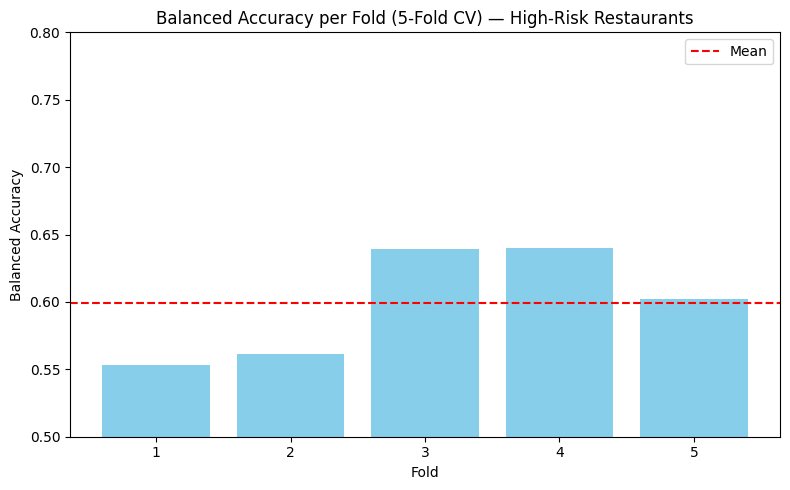

In [ ]:
# Step 0: Authenticate and load full restaurant inspection data
from IPython.display import display
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()
client = bigquery.Client(project="hygiene-prediction-434")

# Pull relevant inspection fields
query = """
SELECT
  inspection_id,
  inspection_date,
  dba_name,
  zip,
  facility_category,
  inspection_type,
  risk,
  violation_count,
  violation_codes,
  has_violation_1,
  has_violation_2,
  has_violation_3,
  has_violation_4,
  has_violation_6,
  has_violation_7,
  has_violation_38,
  has_supervision_violation,
  has_employee_health_violation,
  has_contamination_violation,
  has_temp_control_violation,
  has_food_source_violation,
  has_equipment_violation
FROM `hygiene-prediction-434.HygienePredictionColumn.CleanedInspectionColumn`
WHERE has_violation_38 IS NOT NULL
ORDER BY dba_name, inspection_date
"""

# Load and format
df_seq = client.query(query).to_dataframe()
df_seq["inspection_date"] = pd.to_datetime(df_seq["inspection_date"])

# Step 1: Identify critical violation codes (1–24)
critical_codes = set(range(1, 25))

def extract_codes(v):
    if isinstance(v, dict) and "list" in v:
        return [int(item["element"]) for item in v["list"] if "element" in item]
    return []

def has_critical_violation(v):
    codes = extract_codes(v)
    return int(any(code in critical_codes for code in codes))

df_seq["violation_codes_t+1"] = df_seq.groupby("dba_name")["violation_codes"].shift(-1)
df_seq["has_critical_violation_t+1"] = df_seq["violation_codes_t+1"].apply(has_critical_violation)


# Step 1: Identify critical violation codes (1–24)
critical_codes = set(range(1, 25))

def extract_codes(v):
    if isinstance(v, dict) and "list" in v:
        return [int(item["element"]) for item in v["list"] if "element" in item]
    return []

def has_critical_violation(v):
    codes = extract_codes(v)
    return int(any(code in critical_codes for code in codes))

df_seq["violation_codes_t+1"] = df_seq.groupby("dba_name")["violation_codes"].shift(-1)
df_seq["has_critical_violation_t+1"] = df_seq["violation_codes_t+1"].apply(has_critical_violation)


# Step 2: Total violation count per facility
violation_totals = (
    df_seq.groupby("dba_name")["violation_count"]
    .sum()
    .reset_index()
    .rename(columns={"violation_count": "total_violation_count"})
)

# Classify into 3 risk tiers: low, medium, high
violation_totals["violation_risk_tier"] = pd.qcut(
    violation_totals["total_violation_count"],
    q=3,
    labels=["low", "medium", "high"]
)

# Preview tier distribution
display(violation_totals["violation_risk_tier"].value_counts())

# Step 3: Merge violation risk tiers into full dataset
df_seq = df_seq.merge(violation_totals, on="dba_name", how="left")

# Optional: Filter for restaurant category and one risk tier
FACILITY_CATEGORY = "restaurant"
#RISK_TIER = "high"  # change to "low", "medium", or "high"
#RISK_TIER = "medium"  # change to "low", "medium", or "high"
RISK_TIER = "low"  # change to "low", "medium", or "high"

# Filter restaurant inspections in selected risk tier
df_rest = df_seq[
    (df_seq["facility_category"] == FACILITY_CATEGORY) &
    (df_seq["violation_risk_tier"] == RISK_TIER)
].copy()

# Display size
print(f"{FACILITY_CATEGORY.title()}s in '{RISK_TIER}' risk tier: {len(df_rest)} rows")
df_rest["has_critical_violation_t+1"].value_counts(normalize=True)


# Step 4: Recreate lagged and engineered features

base_features = [
    "zip", "facility_category", "inspection_type", "risk",
    "violation_count", "has_violation_7", "has_supervision_violation", "has_violation_38"
]

# Lag features (re-run even if they were previously created)
for col in base_features:
    df_rest[f"{col}_t-1"] = df_rest.groupby("dba_name")[col].shift(1)
    df_rest[f"{col}_t-2"] = df_rest.groupby("dba_name")[col].shift(2)

# Time deltas
df_rest["days_since_t-1"] = df_rest.groupby("dba_name")["inspection_date"].diff().dt.days
df_rest["days_since_t-2"] = df_rest.groupby("dba_name")["inspection_date"].diff(2).dt.days

# Violation count change
df_rest["violation_count_diff"] = df_rest["violation_count"] - df_rest["violation_count_t-1"]

# Seasonal and inspection flags
df_rest["month"] = df_rest["inspection_date"].dt.month
df_rest["season"] = df_rest["month"].map({12:"winter", 1:"winter", 2:"winter",
                                          3:"spring", 4:"spring", 5:"spring",
                                          6:"summer", 7:"summer", 8:"summer",
                                          9:"fall", 10:"fall", 11:"fall"})

df_rest["is_complaint"] = df_rest["inspection_type"].str.contains("complaint", case=False, na=False).astype(int)
df_rest["is_reinspection"] = df_rest["inspection_type"].str.contains("re[- ]?inspection", case=False, na=False).astype(int)

# Step 5: Drop missing rows for modeling
lag_cols = [f"{col}_t-1" for col in base_features] + [f"{col}_t-2" for col in base_features]
required_features = lag_cols + ["days_since_t-1", "days_since_t-2", "violation_count_diff"]

df_rest = df_rest.dropna(subset=required_features + ["has_critical_violation_t+1"])

# Rebuild ZIP-level critical violation rate for this tier only
zip_violation_rate = df_rest.groupby("zip")["has_critical_violation_t+1"].mean()
df_rest.loc[:, "zip_violation_rate"] = df_rest["zip"].map(zip_violation_rate)


# Define all features
feature_cols_current = [
    "zip", "inspection_type", "risk",
    "violation_count", "has_violation_7",
    "has_supervision_violation", "has_violation_38"
]
feature_cols_lagged_1 = [f"{col}_t-1" for col in feature_cols_current]
feature_cols_lagged_2 = [f"{col}_t-2" for col in feature_cols_current]
engineered_cols = [
    "days_since_t-1", "days_since_t-2", "violation_count_diff",
    "month", "season", "is_complaint", "is_reinspection",
    "zip_violation_rate"
]

# Final feature matrix and target
X_rest = pd.get_dummies(
    df_rest[feature_cols_current + feature_cols_lagged_1 + feature_cols_lagged_2 + engineered_cols],
    drop_first=True
)
y_rest = df_rest["has_critical_violation_t+1"]

# Confirm dimensions
print("Feature matrix:", X_rest.shape)
print("Target distribution:")
display(y_rest.value_counts(normalize=True).rename("proportion").to_frame())

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# Train/validation/test split
X_rest_train, X_rest_temp, y_rest_train, y_rest_temp = train_test_split(
    X_rest, y_rest, test_size=0.3, stratify=y_rest, random_state=42
)

X_rest_val, X_rest_test, y_rest_val, y_rest_test = train_test_split(
    X_rest_temp, y_rest_temp, test_size=0.5, stratify=y_rest_temp, random_state=42
)

# Train XGBoost
xgb_critical = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest_train == 0).sum() / (y_rest_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

xgb_critical.fit(X_rest_train, y_rest_train)

# Predict and evaluate on validation set
y_rest_val_pred = xgb_critical.predict(X_rest_val)

print("Validation Performance — XGBoost (High-Risk Restaurants):")
print(classification_report(y_rest_val, y_rest_val_pred))

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 5-fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_rest == 0).sum() / (y_rest == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Evaluate with balanced accuracy
cv_scores = cross_val_score(
    xgb_cv,
    X_rest,
    y_rest,
    cv=kf,
    scoring=make_scorer(balanced_accuracy_score)
)

# Print and plot
print("Balanced Accuracy Scores:", np.round(cv_scores, 3))
print(f"Mean Balanced Accuracy: {np.mean(cv_scores):.3f}")

plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='skyblue')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', label='Mean')
plt.title("Balanced Accuracy per Fold (5-Fold CV) — High-Risk Restaurants")
plt.xlabel("Fold")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.5, 0.8)
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()


## 🌐 Enriching Restaurant Data with Yelp Attributes

This section explores how to enhance our restaurant inspection dataset by retrieving external attributes from Yelp, using the restaurant's name and address. By matching facilities to Yelp business profiles, we aim to extract rich metadata that may improve model performance and segmentation strategies.

**Yelp features we may incorporate:**
- ⭐ Rating (1–5)
- 💲 Price tier
- 🍽️ Categories (e.g., "Mexican", "Fast Food", "Sushi")
- 📍 Neighborhood or full address match
- 📷 Photo count, review count, tags (optional)

**Goals:**
- Add external signals that reflect public perception, quality, and scale
- Segment or cluster restaurants based on Yelp attributes
- Train enhanced models with deeper understanding of restaurant characteristics


In [ ]:
import requests

# 🔐 Store your Yelp API Key here
YELP_API_KEY = "bQ-qx9Wt-NpgKfTQ-fEDgLwtcXQqeuRH9sCU1VaA5fMnXUAZgFJtcuqLNdban_geK1rLrP_525fHV-42SNUQx1AYkr1my6NnGq35tJu1x5-QDkD4mOu88P__lStUZXYx"  # Replace with your key

# Base URL for Yelp search
YELP_SEARCH_URL = "https://api.yelp.com/v3/businesses/search"

# Auth header
headers = {
    "Authorization": f"Bearer {YELP_API_KEY}"
}


def search_yelp(name, location, limit=1):
    """Search Yelp for a business by name and location (ZIP or full address)"""
    params = {
        "term": name,
        "location": location,
        "limit": limit
    }
    response = requests.get(YELP_SEARCH_URL, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} — {response.text}")
        return None

def extract_yelp_fields(business_json):
    """Flatten Yelp business metadata from a search result"""
    if not business_json or "businesses" not in business_json or not business_json["businesses"]:
        return None

    b = business_json["businesses"][0]
    return {
        "name": b.get("name"),
        "yelp_rating": b.get("rating"),
        "yelp_price": b.get("price", None),
        "yelp_review_count": b.get("review_count"),
        "yelp_categories": [cat["title"] for cat in b.get("categories", [])]
    }




result = search_yelp("McDonald's", "60614")
extracted = extract_yelp_fields(result)
display(extracted)

# Count unique restaurant names in the full dataset
unique_restaurants = df_seq["dba_name"].nunique()
print(f"Total unique restaurants: {unique_restaurants}")



{'name': "McDonald's",
 'yelp_rating': 3.6,
 'yelp_price': '$$',
 'yelp_review_count': 236,
 'yelp_categories': ['Burgers', 'Fast Food']}

Total unique restaurants: 11958


In [ ]:
!pip install requests --quiet


In [ ]:
from google.cloud import bigquery

# Explicitly set your project ID
project_id = "hygiene-prediction-434"  # Replace with your actual project ID

client = bigquery.Client(project=project_id)

query = """
SELECT DISTINCT dba_name, zip, address, state
FROM `hygiene-prediction-434.HygienePredictionRow.CleanedInspectionRow`
WHERE dba_name IS NOT NULL
  AND zip IS NOT NULL
  AND address IS NOT NULL
  AND state IS NOT NULL
ORDER BY RAND()
LIMIT 500
"""
df_sample = client.query(query).to_dataframe()
df_sample.head()

,dba_name,zip,address,state
0,adas food market incorporated,60629,3103 w 63rd st,il
1,weathersby wonder world inc,60628,461 465 e 111th st,il
2,mcm protein bar,60608,2019 s laflin st,il
3,pi18en,60608,1519 w 18th st,il
4,barney's pizza,60651,5648 w chicago ave,il


In [ ]:
!pip install requests --quiet

import pandas as pd
import requests
from google.cloud import bigquery
from itertools import chain
import time

# Yelp API setup
YELP_API_KEY = "qeczPXHn8NOxtheRkWPCD_tFdxyRfPuBTKMRcoxIxM_LxO5jF5X2Dh9Wr-TjsIKHg9i16PhCelg8AtgvQHDlm9ZQgRxGTBuaN90CPBESIRhYbDURuPripVZxna4LaHYx"  # Replace with your key
SEARCH_URL = "https://api.yelp.com/v3/businesses/search"
HEADERS = {"Authorization": f"Bearer {YELP_API_KEY}"}

def search_yelp(name, zip_code, max_retries=5):
    params = {"term": name, "location": zip_code, "limit": 1}
    for retry in range(max_retries):
        response = requests.get(SEARCH_URL, headers=HEADERS, params=params)
        if response.status_code == 200:
            businesses = response.json().get("businesses", [])
            if businesses:
                return businesses[0]
            return None
        elif response.status_code == 429:
            wait_time = 2 ** retry
            print(f"Rate limit hit. Waiting {wait_time} seconds before retrying...")
            time.sleep(wait_time)
        else:
            print(f"Error: {response.status_code} — {response.text}")
            return None
    print("Max retries exceeded.")
    return None


# BigQuery client
client = bigquery.Client(project="hygiene-prediction-434")

# Fetch the data from BigQuery
query = """
SELECT DISTINCT dba_name, zip, address, state
FROM `hygiene-prediction-434.HygienePredictionRow.CleanedInspectionRow`
WHERE facility_type = 'restaurant'
  AND dba_name IS NOT NULL
  AND zip IS NOT NULL
  AND address IS NOT NULL
  AND state IS NOT NULL
ORDER BY RAND()
LIMIT 50
"""
df_sample = client.query(query).to_dataframe()

# Verify the number of rows returned
print(f"Number of rows from BigQuery: {len(df_sample)}")

# Perform Yelp search for each row in the DataFrame with progress and rate limiting
matches = []
total_restaurants = len(df_sample)
start_time = time.time()

for i, (_, row) in enumerate(df_sample.iterrows(), 1):
    result = search_yelp(row['dba_name'], row['zip'])
    if result:
        matches.append({
            "name": row['dba_name'],
            "zip": row['zip'],
            "address": row['address'],
            "state": row['state'],
            "yelp_id": result.get("id"),
            "yelp_rating": result.get("rating"),
            "yelp_price": result.get("price", "N/A"),
            "yelp_review_count": result.get("review_count"),
            "yelp_categories": [cat['title'] for cat in result.get("categories", [])]
        })


    # Print progress and estimate remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_restaurant = elapsed_time / i
    remaining_time = avg_time_per_restaurant * (total_restaurants - i)

    print(f"Processed {i}/{total_restaurants} restaurants. "
          f"Estimated time remaining: {int(remaining_time)} seconds.")

    # Rate limiting: Pause for a short duration
    time.sleep(2)  # Adjust as needed

# Create a DataFrame from the matches
matched_df = pd.DataFrame(matches)

# Extract and analyze Yelp categories
all_categories = list(chain.from_iterable(matched_df["categories"]))
unique_categories = sorted(set(all_categories))

# Print the unique categories
print("\nUnique Yelp Categories:")
for category in unique_categories:
    print(category)

# Display the matched DataFrame
matched_df.head()
matched_df.info()

Number of rows from BigQuery: 500
Rate limit hit. Waiting 1 seconds before retrying...
Rate limit hit. Waiting 2 seconds before retrying...
Rate limit hit. Waiting 4 seconds before retrying...
Rate limit hit. Waiting 8 seconds before retrying...
Rate limit hit. Waiting 16 seconds before retrying...
Max retries exceeded.
Processed 1/500 restaurants. Estimated time remaining: 15612 seconds.
Rate limit hit. Waiting 1 seconds before retrying...
Rate limit hit. Waiting 2 seconds before retrying...
Rate limit hit. Waiting 4 seconds before retrying...
Rate limit hit. Waiting 8 seconds before retrying...
Rate limit hit. Waiting 16 seconds before retrying...
Max retries exceeded.
Processed 2/500 restaurants. Estimated time remaining: 16078 seconds.
Rate limit hit. Waiting 1 seconds before retrying...
Rate limit hit. Waiting 2 seconds before retrying...
Rate limit hit. Waiting 4 seconds before retrying...
Rate limit hit. Waiting 8 seconds before retrying...


KeyboardInterrupt: 

In [ ]:
matched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        394 non-null    object
 1   zip         394 non-null    int64 
 2   yelp_id     394 non-null    object
 3   categories  394 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.4+ KB


In [ ]:
from itertools import chain
from collections import Counter

all_categories = list(chain.from_iterable(matched_df["categories"]))
category_counts = Counter(all_categories)

# Convert to sorted DataFrame
df_categories = (
    pd.DataFrame(category_counts.items(), columns=["category", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)
df_categories.head(20)

,category,count
0,Sandwiches,42
1,Coffee & Tea,37
2,Fast Food,34
3,Pizza,26
4,Italian,26
5,Mexican,25
6,Burgers,23
7,American,22
8,Breakfast & Brunch,20
9,Grocery,20


In [ ]:
price_counts = matched_df["price"].value_counts().sort_index()
print(price_counts)


KeyError: 'yelp_price'

In [ ]:
# Fetch the data from BigQuery
query = """
SELECT DISTINCT dba_name, zip, address, state
FROM `hygiene-prediction-434.HygienePredictionRow.CleanedInspectionRow`
WHERE facility_type = 'restaurant'
  AND dba_name IS NOT NULL
  AND zip IS NOT NULL
  AND address IS NOT NULL
  AND state IS NOT NULL
ORDER BY RAND()
LIMIT 500
"""
df_sample = client.query(query).to_dataframe()

In [ ]:
df_sample.head()

,dba_name,zip,address,state
0,la petite folie,60615,1504 e 55th st,il
1,do rite donut kiosk,60611,835 n michigan ave,il
2,positanos pizza,60632,4312 w 55th st,il
3,grk greek kitchen,60611,251 e huron st,il
4,million's crab,60652,7519 s cicero ave,il


In [ ]:
!pip install python-dotenv --quiet


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful